In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

## Analysis of total cases

![](out/seihrd.png)

This is the idealised SEIR model with isolation (Hospitalisation) and Deaths. In the model below, we also want to capture the discharge information (H to R) so we capture them in a new compartment G (discharGe).

The data we have is:
- newly reported cases (entries into the I compartment)
- cumulative newly reported cases (square I box)
- number of people in isolation (H)
- cumulative number of people ever in isolation (square box H)
- number of discharged from isolation
- number of deaths

In [2]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+H+G+R),
        b*S*I/(S+E+I+H+G+R)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        a*I,
        m*I,
        g*E,
        e*I
    ]

In [3]:
read_file = True
if read_file:
    raw_data = pd.read_csv("../samoa/samoa-data/samoa_press_release_data.csv", header=0, dayfirst=True, parse_dates=True, skiprows=[1])

In [4]:
time, cE, H, cH, D, G = raw_data.iloc[:,1:].values.T

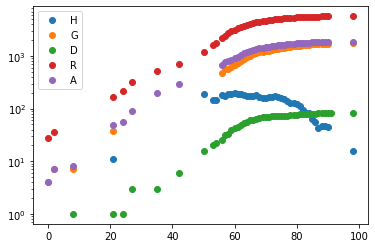

In [5]:
plt.semilogy(time, H, 'o', time, G, 'o', time, D, 'o', time, cE, 'o', time , cH, 'o')
plt.legend("HGDRA")

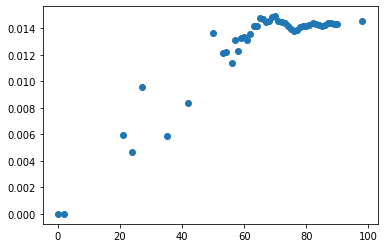

In [6]:
plt.plot(time,[d/ce if ce else None for d,ce in zip(D,cE)],'o')

In [7]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
start = 0
data_time = time[start:]
data_pd = data_pd[start:,:]

p0 = [1.5, 1e-6, 0, 1e-6, 1e-6, 0.015]
config = {
    "grid_size": 200,
    "basis_number": 40,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.25],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(data_time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy(p0),
}

In [8]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [9]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [10]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 1e2

In [11]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

(0, 3000)

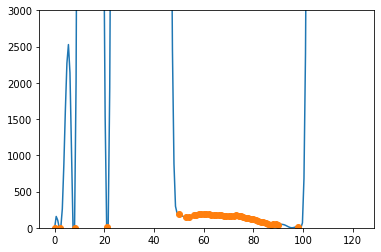

In [12]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[3])
plt.plot(time, H, 'o')
plt.ylim([0, 3000])

In [13]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du

 120  8.2831049e+01 0.00e+00 3.50e-01  -8.6 2.30e+03 -14.3 1.00e+00 1.00e+00f  1
 130  8.2830977e+01 0.00e+00 2.45e-01  -8.6 3.35e+03 -14.5 1.00e+00 3.01e-01f  2
 140  8.2830891e+01 0.00e+00 1.37e-01  -8.6 9.30e+02 -13.9 1.00e+00 1.00e+00f  1
 150  8.2830797e+01 0.00e+00 1.42e-01  -8.6 1.00e+03 -13.2 1.00e+00 2.44e-01h  1
 160  8.2831393e+01 0.00e+00 6.16e-01  -8.6 8.69e+03 -13.5 1.00e+00 4.35e-01h  1
 170  8.2830524e+01 0.00e+00 1.64e-01  -8.6 8.63e+03 -13.7 1.00e+00 9.74e-02f  3
 180  8.2830386e+01 0.00e+00 1.36e-01  -8.6 2.11e+03 -14.0 1.00e+00 5.00e-01f  2
 190  8.2830283e+01 0.00e+00 5.22e-02  -8.6 7.03e+02 -13.4 7.30e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  8.2830209e+01 0.00e+00 7.52e-02  -8.6 1.88e+03 -10.9 6.66e-01 1.63e-02h  4
 210  8.2830151e+01 0.00e+00 2.16e-01  -8.6 6.82e+02 -12.1 1.00e+00 2.53e-01h  2
 220  8.2830087e+01 0.00e+00 2.22e-01  -8.6 5.23e+02 -12.3 1.00e+00 5.00e-01h  2
 230  8.2830015e+01 0.00e+00

                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.4271059e+01 0.00e+00 3.18e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  8.8464211e+01 0.00e+00 1.63e+00  -1.0 1.17e+03    -  4.97e-01 1.00e+00f  1
  20  8.4441719e+01 0.00e+00 2.38e+00  -3.8 1.11e+04    -  5.27e-01 9.14e-01f  1
  30  8.2970323e+01 0.00e+00 1.05e-02  -5.7 1.78e+01  -6.9 2.80e-01 6.80e-02f  1
  40  8.2929109e+01 0.00e+00 2.43e+00  -5.7 4.42e+03 -11.6 1.00e+00 5.92e-01f  1
 

 230  8.2969679e+01 0.00e+00 2.04e-01  -8.6 5.10e+02 -12.6 9.77e-01 1.00e+00h  1
 240  8.2969511e+01 0.00e+00 1.83e-01  -8.6 1.44e+03 -11.9 5.34e-01 1.39e-01h  3
 250  8.2969353e+01 0.00e+00 1.85e-01  -8.6 6.64e+03 -13.1 7.76e-01 1.23e-01h  3
 260  8.2969213e+01 0.00e+00 1.35e-01  -8.6 6.30e+03 -13.4 2.48e-02 5.28e-02f  1
 270  8.2969049e+01 0.00e+00 3.96e-02  -8.6 1.43e+03 -12.7 1.00e+00 1.00e+00h  1
 280  8.2968912e+01 0.00e+00 1.77e-02  -8.6 4.25e+01 -10.3 1.00e+00 1.00e+00h  1
 290  8.2988993e+01 0.00e+00 7.70e+00  -8.6 4.68e+02 -10.5 8.36e-04 3.39e-14h 39
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  8.2968746e+01 0.00e+00 1.34e-01  -8.6 1.33e+03 -12.6 1.00e+00 1.00e+00h  1
 310  8.2968620e+01 0.00e+00 2.59e-02  -8.6 1.75e+03 -12.8 1.00e+00 1.00e+00f  1
 320  8.2968567e+01 0.00e+00 2.85e-03  -8.6 1.12e+02 -11.3 1.00e+00 1.00e+00f  1
 330  8.2971147e+01 0.00e+00 2.17e+00  -8.6 8.65e+01 -10.6 8.87e-01 7.77e-01h  1
 340  8.2968487e+01 0.00e+00

  40  8.3114854e+01 0.00e+00 2.23e-01  -5.7 7.18e+02 -10.8 1.00e+00 1.00e+00f  1
  50  8.3112180e+01 0.00e+00 2.45e-01  -5.7 5.50e+02 -12.0 1.00e+00 1.00e+00f  1
  60  8.3111412e+01 0.00e+00 5.41e-01  -5.7 4.70e+02 -11.3 1.00e+00 5.00e-01h  2
  70  8.3110884e+01 0.00e+00 1.42e-01  -5.7 3.15e+02 -12.0 1.00e+00 1.00e+00h  1
  80  8.3110331e+01 0.00e+00 3.09e-01  -5.7 3.46e+03 -12.3 1.00e+00 4.12e-01f  2
  90  8.3109785e+01 0.00e+00 2.94e-01  -5.7 5.92e+03 -13.0 1.06e-01 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.3109170e+01 0.00e+00 5.06e-01  -5.7 6.70e+03 -11.8 2.67e-01 1.04e-01f  1
 110  8.3108642e+01 0.00e+00 3.50e-01  -5.7 1.00e+03 -11.6 1.00e+00 3.58e-01f  2
 120  8.3108185e+01 0.00e+00 1.74e-01  -5.7 4.25e+02 -11.9 1.00e+00 6.75e-01f  1
 130  8.3107749e+01 0.00e+00 1.18e-01  -5.7 4.28e+02 -12.1 1.00e+00 5.00e-01h  2
 140  8.3107318e+01 0.00e+00 1.42e-01  -5.7 1.34e+03 -12.8 1.00e+00 2.50e-01h  3
 150  8.3106958e+01 0.00e+00

 380  8.3187448e+01 0.00e+00 5.14e-01  -8.6 7.32e+05 -13.8 5.54e-04 4.75e-03f  1
 390  8.3187307e+01 0.00e+00 5.59e-03  -8.6 5.85e+02 -12.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  8.3187019e+01 0.00e+00 4.92e-01  -8.6 3.75e-01  -6.0 1.00e+00 4.11e-01f  1
 410  8.3186950e+01 0.00e+00 5.36e-02  -8.6 7.12e+01 -10.3 1.00e+00 1.00e+00h  1
 420  8.3186839e+01 0.00e+00 2.20e-03  -8.6 1.12e+01  -9.6 1.00e+00 1.00e+00f  1
 430  8.3186752e+01 0.00e+00 3.59e-04  -8.6 5.66e+00  -9.3 1.00e+00 1.00e+00h  1
 440  8.3186679e+01 0.00e+00 6.54e-02  -8.6 9.43e+03 -14.1 2.96e-01 1.49e-02f  1
 450  8.3186555e+01 0.00e+00 3.58e-02  -8.6 6.24e+03 -13.5 1.31e-01 6.43e-02f  1
 460  8.3186240e+01 0.00e+00 1.05e-01  -8.6 1.60e+01  -8.3 8.55e-01 1.93e-01f  1
 470  8.3186210e+01 0.00e+00 1.09e-03  -8.6 1.66e+02 -12.6 3.31e-01 7.81e-01h  1
 480  8.3186206e+01 0.00e+00 1.18e-04  -8.6 8.69e-01 -10.0 1.00e+00 1.00e+00h  1
 490  8.3186205e+01 0.00e+00

  80  8.3384668e+01 0.00e+00 1.11e-01  -5.7 2.70e+02 -11.8 1.00e+00 1.00e+00f  1
  90  8.3383492e+01 0.00e+00 5.50e-01  -5.7 6.12e+02 -12.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.3382186e+01 0.00e+00 6.74e-01  -5.7 6.82e+02 -11.4 1.00e+00 6.39e-01f  1
 110  8.3380503e+01 0.00e+00 1.23e+00  -5.7 6.74e+02 -12.5 1.00e+00 5.13e-01f  1
 120  8.3378386e+01 0.00e+00 5.67e-01  -5.7 7.77e+02 -12.8 1.00e+00 5.53e-01f  1
 130  8.3376956e+01 0.00e+00 6.03e-01  -5.7 4.63e+03 -12.1 1.64e-01 2.90e-01f  1
 140  8.3375781e+01 0.00e+00 2.02e-01  -5.7 3.66e+02 -11.5 1.00e+00 1.00e+00f  1
 150  8.3374636e+01 0.00e+00 1.23e-01  -5.7 9.76e+02 -12.6 1.00e+00 1.00e+00f  1
 160  8.3373501e+01 0.00e+00 2.60e-01  -5.7 4.25e+02 -11.1 5.70e-01 2.50e-01f  3
 170  8.3372507e+01 0.00e+00 1.78e-01  -5.7 1.27e+03 -11.3 1.00e+00 2.50e-01f  3
 180  8.3371713e+01 0.00e+00 1.74e-01  -5.7 3.98e+02 -11.6 7.80e-01 1.00e+00f  1
 190  8.3371114e+01 0.00e+00

  20  1.0739751e+02 0.00e+00 6.15e+01  -1.0 8.30e+04    -  3.90e-03 2.19e-01f  2
  30  1.0626061e+02 0.00e+00 2.17e-01  -1.0 8.16e+02    -  1.00e+00 1.00e+00f  1
  40  8.3641299e+01 0.00e+00 1.67e+00  -3.8 5.90e+03    -  1.00e+00 1.00e+00f  1
  50  8.3614442e+01 0.00e+00 1.95e-02  -5.7 9.16e+01  -9.4 9.67e-01 1.00e+00f  1
  60  8.3612110e+01 0.00e+00 1.58e+00  -5.7 3.51e+03 -13.2 1.00e+00 9.60e-01f  1
  70  8.3611204e+01 0.00e+00 1.46e-01  -5.7 5.02e+02 -12.5 1.00e+00 1.00e+00f  1
  80  8.3610303e+01 0.00e+00 3.58e-01  -5.7 7.42e+02 -13.2 1.00e+00 1.00e+00f  1
  90  8.3609996e+01 0.00e+00 7.51e-03  -5.7 5.72e+01 -12.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.3609899e+01 0.00e+00 1.06e-01  -5.7 2.08e+02 -11.4 6.79e-01 1.00e+00f  1
 110  8.3609825e+01 0.00e+00 9.18e-03  -5.7 6.06e+01 -12.9 1.00e+00 1.00e+00h  1
 120  8.3609736e+01 0.00e+00 1.85e-01  -5.7 6.63e+02 -14.0 1.00e+00 5.00e-01h  2
 130  8.3609821e+01 0.00e+00

  30  8.4822092e+01 0.00e+00 1.49e+01  -3.8 2.64e+03    -  5.29e-01 1.00e+00f  1
  40  8.3871276e+01 0.00e+00 1.14e-02  -5.7 1.84e+02  -9.2 1.00e+00 1.00e+00f  1
  50  8.3858488e+01 0.00e+00 4.11e+00  -5.7 6.61e+03 -12.2 1.00e+00 1.00e+00f  1
  60  8.3854594e+01 0.00e+00 2.85e+00  -5.7 1.54e+03 -12.5 1.00e+00 1.00e+00f  1
  70  8.3852813e+01 0.00e+00 3.03e-01  -5.7 3.64e+02 -11.8 1.00e+00 1.00e+00f  1
  80  8.3852066e+01 0.00e+00 7.23e-01  -5.7 6.16e+02 -13.4 1.00e+00 1.00e+00h  1
  90  8.3851840e+01 0.00e+00 1.05e+00  -5.7 2.34e+03 -14.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.3851729e+01 0.00e+00 1.88e-02  -5.7 1.10e+02 -12.4 1.00e+00 1.00e+00f  1
 110  8.3853242e+01 0.00e+00 4.03e+00  -5.7 6.15e+03    -  1.00e+00 5.00e-01h  2
 120  8.3851440e+01 0.00e+00 1.94e-01  -5.7 1.03e+04    -  1.00e+00 6.25e-02h  5
 130  8.3851209e+01 0.00e+00 2.05e+00  -5.7 1.32e+05    -  2.21e-01 3.68e-02f  4
 140  8.3850952e+01 0.00e+00

                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.4316963e+01 0.00e+00 3.18e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  9.1203559e+01 0.00e+00 3.58e+00  -1.0 3.14e+01  -4.0 9.92e-01 1.00e+00f  1
  20  9.9997546e+01 0.00e+00 1.42e+01  -1.0 2.79e+02  -6.4 1.00e+00 1.00e+00f  1
  30  1.0619310e+02 0.00e+00 8.18e-01  -1.0 1.63e+03    -  1.00e+00 1.00e+00f  1
  40  8.4209346e+01 0.00e+00 1.24e-02  -3.8 3.31e+01  -7.8 1.00e+00 1.00e+00f  1
 

  30  1.0610565e+02 0.00e+00 3.18e+01  -1.0 7.67e+03    -  1.00e+00 1.00e+00f  1
  40  8.4690659e+01 0.00e+00 2.20e-02  -3.8 5.34e+01  -7.8 1.00e+00 1.00e+00f  1
  50  8.4636406e+01 0.00e+00 8.91e-02  -3.8 4.85e+02 -10.7 1.00e+00 1.00e+00f  1
  60  8.4625718e+01 0.00e+00 8.93e+00  -3.8 6.71e+03    -  1.00e+00 2.50e-01f  3
  70  8.4622657e+01 0.00e+00 7.29e-02  -3.8 1.25e+02    -  1.00e+00 1.00e+00h  1
  80  8.4602300e+01 0.00e+00 1.84e+01  -5.7 6.91e+03 -12.8 1.00e+00 2.50e-01f  3
  90  8.4598114e+01 0.00e+00 7.89e+00  -5.7 3.09e+03 -13.0 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.4596952e+01 0.00e+00 1.72e+00  -5.7 5.23e+03 -13.3 1.00e+00 5.00e-01f  2
 110  8.4595707e+01 0.00e+00 5.60e-01  -5.7 4.37e+02 -11.8 1.00e+00 1.00e+00f  1
 120  8.4594032e+01 0.00e+00 6.88e-02  -5.7 1.03e+02 -11.1 1.00e+00 1.00e+00f  1
 130  8.4592242e+01 0.00e+00 5.89e+00  -5.7 1.65e+03 -12.3 1.00e+00 1.00e+00f  1
 140  8.4590963e+01 0.00e+00

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.6251116e+01 0.00e+00 1.48e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  9.3633686e+01 0.00e+00 6.09e+00  -1.0 3.80e+01  -4.0 9.92e-01 1.00e+00f  1
  20  1.1178796e+02 0.00e+00 6.12e+02  -1.0 4.13e+04    -  9.95e-03 2.09e-01f  3
  30  1.0610831e+02 0.00e+00 3.94e+01  -1.0 7.72e+03    -  1.00e+00 1.00e+00f  1
  40  8.5757470e+0

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  8.7585838e+01 0.00e+00 2.32e+02  -1.0 0.00e+00    -  0.00e+00 0.

 230  8.5849316e+01 0.00e+00 5.85e+00  -5.7 4.03e+02    -  8.48e-02 1.00e+00f  1
 240  8.5786459e+01 0.00e+00 9.33e-01  -5.7 2.23e+02    -  1.41e-02 1.41e-01f  1
 250  8.5760759e+01 0.00e+00 5.41e-01  -5.7 1.05e+02    -  1.72e-01 5.65e-01f  1
 260  8.5757017e+01 0.00e+00 6.38e-02  -5.7 4.68e+01  -8.7 1.00e+00 1.00e+00f  1
 270  8.5736410e+01 0.00e+00 1.75e+00  -5.7 8.35e+02 -10.8 1.00e+00 5.14e-01f  1
 280  8.5663632e+01 0.00e+00 3.46e-01  -5.7 2.33e+02  -8.3 1.69e-01 3.80e-01f  1
 290  8.5658799e+01 0.00e+00 2.48e-02  -5.7 8.44e+01 -10.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  8.5658720e+01 0.00e+00 6.42e-04  -5.7 2.65e+02 -13.2 1.00e+00 1.00e+00h  1
 310  8.5658457e+01 0.00e+00 6.68e-03  -8.6 2.76e+03 -13.4 8.22e-01 3.83e-01h  2
 320  8.5658326e+01 0.00e+00 1.71e-03  -8.6 7.92e+01 -11.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 329

                                   (scaled)                 (unscaled)
Object

  20  1.2314352e+02 0.00e+00 5.28e+02  -1.0 1.21e+03  -6.9 1.00e+00 1.00e+00f  1
  30  1.0807149e+02 0.00e+00 3.41e+02  -1.0 2.40e+03  -8.8 1.00e+00 1.00e+00f  1
  40  9.5489879e+01 0.00e+00 2.93e+01  -1.7 1.04e+03    -  8.56e-01 1.00e+00f  1
  50  8.9145090e+01 0.00e+00 4.46e+01  -3.8 4.86e+03 -10.8 1.00e+00 1.00e+00f  1
  60  8.9042551e+01 0.00e+00 1.13e+02  -3.8 3.89e+03 -12.0 1.00e+00 8.73e-01f  1
  70  8.8999221e+01 0.00e+00 9.62e+01  -3.8 3.78e+04    -  4.78e-01 6.17e-02f  4
  80  8.8970890e+01 0.00e+00 5.62e+01  -3.8 1.64e+03 -12.0 1.00e+00 1.00e+00f  1
  90  8.8951618e+01 0.00e+00 4.82e+01  -3.8 4.33e+04 -13.2 6.22e-01 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.8942743e+01 0.00e+00 3.84e+00  -3.8 3.12e+02 -11.6 1.00e+00 1.00e+00f  1
 110  8.8935236e+01 0.00e+00 3.37e+01  -3.8 2.16e+03 -12.7 1.00e+00 1.00e+00f  1
 120  8.8922229e+01 0.00e+00 3.53e+01  -3.8 1.67e+03    -  1.00e+00 1.00e+00f  1
 130  8.8903693e+01 0.00e+00

  30  9.1401972e+01 0.00e+00 5.83e+01  -3.8 7.43e+04    -  1.59e-01 1.15e-01f  1
  40  8.9115941e+01 0.00e+00 7.85e+01  -3.8 9.40e+02 -10.4 5.70e-02 1.00e+00f  1
  50  8.8280496e+01 0.00e+00 2.04e+00  -3.8 7.17e+01  -8.0 1.00e+00 1.00e+00f  1
  60  8.8214433e+01 0.00e+00 4.85e+00  -3.8 9.51e+02    -  1.00e+00 1.00e+00f  1
  70  8.8190392e+01 0.00e+00 1.00e-01  -5.7 1.13e+04    -  1.00e+00 5.00e-01f  2
  80  8.8190073e+01 0.00e+00 2.15e-03  -8.6 5.83e+01    -  1.00e+00 7.91e-01f  1

Number of Iterations....: 83

                                   (scaled)                 (unscaled)
Objective...............:   8.8190072088569551e+01    8.8190072088569551e+01
Dual infeasibility......:   2.0830504020611379e-09    2.0830504020611379e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.4461851505674377e-09    4.4461851505674377e-09
Overall NLP error.......:   4.4461851505674377e-09    4.4461851505674377e-09


Number of objective funct

 130  9.6297391e+01 0.00e+00 6.27e+02  -3.8 1.27e+04 -10.3 3.37e-01 6.77e-02f  2
 140  9.5829531e+01 0.00e+00 1.38e+01  -3.8 7.61e+02 -11.4 1.00e+00 1.00e+00f  1
 150  9.5814526e+01 0.00e+00 4.96e+01  -3.8 3.72e+03    -  1.00e+00 5.00e-01f  2
 160  9.5811957e+01 0.00e+00 9.74e+00  -3.8 2.54e+03    -  1.00e+00 5.00e-01f  2
 170  9.5803207e+01 0.00e+00 2.86e+01  -5.7 3.16e+03 -13.0 1.00e+00 1.00e+00f  1
 180  9.5801075e+01 0.00e+00 1.33e+00  -5.7 3.99e+02 -12.3 1.00e+00 1.00e+00h  1
 190  9.5800039e+01 0.00e+00 4.99e+00  -5.7 8.32e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  9.5799454e+01 0.00e+00 6.80e-01  -8.6 3.26e+02    -  1.00e+00 9.66e-01f  1

Number of Iterations....: 204

                                   (scaled)                 (unscaled)
Objective...............:   9.5799453159814220e+01    9.5799453159814220e+01
Dual infeasibility......:   1.7636843100196772e-11    1.7636843100196772e-11
Constraint vio

 130  1.0445783e+02 0.00e+00 2.00e+02  -3.8 9.23e+02 -11.0 1.00e+00 1.00e+00f  1
 140  1.0389405e+02 0.00e+00 1.44e+03  -3.8 2.29e+03 -10.4 1.00e+00 3.97e-01f  2
 150  1.0276064e+02 0.00e+00 8.18e+02  -3.8 9.31e+04 -11.6 5.91e-02 1.10e-02f  3
 160  1.0255711e+02 0.00e+00 2.38e+01  -3.8 1.88e+03 -13.1 1.00e+00 1.00e+00f  1
 170  1.0255200e+02 0.00e+00 1.33e+01  -3.8 1.21e+03 -12.8 1.00e+00 1.00e+00f  1
 180  1.0254615e+02 0.00e+00 3.05e+00  -3.8 6.62e+02    -  1.00e+00 1.00e+00f  1
 190  1.0253758e+02 0.00e+00 1.79e+00  -5.7 7.29e+02 -12.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0253404e+02 0.00e+00 1.45e+02  -5.7 6.59e+03 -13.2 1.00e+00 5.00e-01f  2
 210  1.0253084e+02 0.00e+00 9.59e+00  -5.7 1.84e+03    -  1.00e+00 1.00e+00f  1
 220  1.0253002e+02 0.00e+00 4.29e-07  -8.6 2.26e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 221

                                   (scaled)                 (unscaled)
Object

  70  1.1897937e+02 0.00e+00 3.93e+02  -2.5 9.00e+02 -11.1 1.00e+00 1.00e+00f  1
  80  1.1874408e+02 0.00e+00 2.41e+02  -2.5 9.95e+02 -11.3 1.00e+00 1.00e+00f  1
  90  1.1867895e+02 0.00e+00 1.09e+01  -2.5 3.13e+02    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1834379e+02 0.00e+00 3.43e+02  -3.8 2.98e+03 -11.1 1.00e+00 1.00e+00f  1
 110  1.1824598e+02 0.00e+00 2.97e+00  -3.8 1.18e+02  -9.6 1.00e+00 1.00e+00f  1
 120  1.1809674e+02 0.00e+00 1.87e+02  -3.8 1.75e+03  -9.8 1.00e+00 5.00e-01f  2
 130  1.1778798e+02 0.00e+00 6.58e+02  -3.8 2.16e+03 -10.1 1.00e+00 1.00e+00f  1
 140  1.1697859e+02 0.00e+00 8.13e+02  -3.8 9.46e+02 -10.3 1.00e+00 1.00e+00f  1
 150  1.1535494e+02 0.00e+00 1.75e+03  -3.8 1.45e+03 -10.6 1.00e+00 3.66e-01f  2
 160  1.1343206e+02 0.00e+00 5.87e+01  -3.8 1.91e+03 -11.8 1.00e+00 1.00e+00f  1
 170  1.1337746e+02 0.00e+00 2.59e+01  -3.8 1.15e+04    -  1.00e+00 1.00e+00f  1
 180  1.1337822e+02 0.00e+00

  10  1.4081294e+02 0.00e+00 4.29e+02  -1.0 6.58e+02    -  9.35e-01 1.00e+00f  1
  20  1.4883782e+02 0.00e+00 5.78e+01  -1.0 2.35e+02  -6.4 1.00e+00 1.00e+00f  1
  30  1.5914283e+02 0.00e+00 1.38e+03  -1.0 1.50e+04    -  4.45e-01 1.13e-01f  3
  40  1.5996645e+02 0.00e+00 1.57e+03  -1.0 2.08e+06    -  6.41e-03 1.24e-03f  3
  50  1.5926002e+02 0.00e+00 1.79e+02  -1.0 1.31e+03  -8.7 1.00e+00 1.00e+00f  1
  60  1.6095186e+02 0.00e+00 1.71e+01  -1.0 2.65e+02    -  1.00e+00 1.00e+00f  1
  70  1.4301663e+02 0.00e+00 9.27e+02  -2.5 9.01e+03 -10.3 1.00e+00 2.50e-01f  3
  80  1.4208765e+02 0.00e+00 5.47e+02  -2.5 5.26e+03 -10.5 1.00e+00 5.00e-01f  2
  90  1.4145184e+02 0.00e+00 5.68e+02  -2.5 1.11e+03 -10.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4114903e+02 0.00e+00 3.00e+01  -2.5 2.70e+02 -10.6 1.00e+00 1.00e+00f  1
 110  1.4106002e+02 0.00e+00 2.24e+01  -2.5 8.46e+02    -  1.00e+00 1.00e+00f  1
 120  1.4062587e+02 0.00e+00

  40  1.9461695e+02 0.00e+00 1.20e+03  -1.0 6.82e+02  -7.6 9.85e-01 1.00e+00f  1
  50  1.9758396e+02 0.00e+00 3.10e+03  -1.0 3.69e+03  -8.7 1.00e+00 5.00e-01f  2
  60  1.9878221e+02 0.00e+00 9.37e+03  -1.0 1.55e+04    -  1.00e+00 2.50e-01f  3
  70  1.9908404e+02 0.00e+00 6.90e+03  -1.0 5.85e+03    -  1.00e+00 5.00e-01f  2
  80  1.8417975e+02 0.00e+00 4.81e+03  -2.5 6.42e+03  -9.6 1.00e+00 1.00e+00f  1
  90  1.8120043e+02 0.00e+00 1.12e+02  -2.5 7.00e+02  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7990908e+02 0.00e+00 9.03e+02  -2.5 1.02e+03 -10.1 1.00e+00 1.00e+00f  1
 110  1.7914353e+02 0.00e+00 8.13e+02  -2.5 3.12e+03 -10.8 1.00e+00 1.00e+00f  1
 120  1.7888287e+02 0.00e+00 6.19e+00  -2.5 1.97e+02  -9.7 1.00e+00 1.00e+00f  1
 130  1.7866677e+02 0.00e+00 5.03e+01  -2.5 4.62e+02  -9.9 1.00e+00 1.00e+00f  1
 140  1.7815747e+02 0.00e+00 1.22e+03  -2.5 2.13e+03 -10.2 1.00e+00 1.00e+00f  1
 150  1.7692129e+02 0.00e+00

  10  1.5219686e+02 0.00e+00 2.04e+02  -1.0 1.24e+03    -  8.90e-01 1.00e+00f  1
  20  1.6672028e+02 0.00e+00 2.57e+02  -1.0 1.14e+04    -  4.00e-01 1.63e-01f  3
  30  1.9126280e+02 0.00e+00 4.47e+02  -1.0 1.53e+04    -  8.56e-01 2.46e-01f  3
  40  2.0739797e+02 0.00e+00 6.20e+02  -1.0 1.40e+04    -  1.00e+00 1.00e+00f  1
  50  2.3268122e+02 0.00e+00 1.85e+02  -1.0 3.03e+02  -7.3 1.00e+00 1.00e+00f  1
  60  2.5805765e+02 0.00e+00 4.21e+03  -1.0 1.13e+05  -8.4 7.27e-02 3.04e-02f  1
  70  2.6323430e+02 0.00e+00 2.26e+03  -1.0 1.47e+03  -8.6 1.00e+00 1.00e+00f  1
  80  2.6380808e+02 0.00e+00 9.68e+01  -1.0 2.29e+02  -8.7 1.00e+00 1.00e+00f  1
  90  2.4778624e+02 0.00e+00 3.13e+03  -2.5 1.68e+03  -9.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.4498355e+02 0.00e+00 4.23e+03  -2.5 2.57e+03  -9.6 1.00e+00 5.00e-01f  2
 110  2.4336829e+02 0.00e+00 5.95e+02  -2.5 6.30e+02  -9.8 1.00e+00 1.00e+00f  1
 120  2.4283622e+02 0.00e+00

  10  1.6405619e+02 0.00e+00 4.71e+02  -1.0 1.31e+03    -  8.78e-01 1.00e+00f  1
  20  1.7456493e+02 0.00e+00 2.03e+02  -1.0 1.43e+05    -  1.71e-01 2.93e-02f  4
  30  1.4513057e+02 0.00e+00 2.21e+01  -1.7 5.61e+01  -5.6 1.00e+00 1.00e+00f  1
  40  1.3627524e+02 0.00e+00 2.15e+01  -1.7 5.64e+02    -  1.00e+00 1.00e+00f  1
  50  1.3139532e+02 0.00e+00 5.00e+01  -2.5 1.08e+02  -8.9 1.00e+00 1.00e+00f  1
  60  1.3095767e+02 0.00e+00 7.69e-03  -3.8 1.79e+02    -  1.00e+00 1.00e+00h  1
  70  1.3094287e+02 0.00e+00 2.52e-02  -5.7 4.51e+02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 77

                                   (scaled)                 (unscaled)
Objective...............:   1.3094261957381158e+02    1.3094261957381158e+02
Dual infeasibility......:   2.6541143318815626e-09    2.6541143318815626e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.6067973547660373e-09    1.6067973547660373e-09
Overall NLP error......

  50  1.6081733e+02 0.00e+00 1.54e+00  -3.8 3.05e+01  -7.9 1.00e+00 1.00e+00f  1
  60  1.6079696e+02 0.00e+00 1.36e-01  -5.7 1.12e+03    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 67

                                   (scaled)                 (unscaled)
Objective...............:   1.6079670108725773e+02    1.6079670108725773e+02
Dual infeasibility......:   4.1048766150942493e-10    4.1048766150942493e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.5071930250553130e-10    9.5071930250553130e-10
Overall NLP error.......:   9.5071930250553130e-10    9.5071930250553130e-10


Number of objective function evaluations             = 112
Number of objective gradient evaluations             = 68
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 112
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 68
N

  20  2.3684891e+02 0.00e+00 5.43e+01  -1.0 2.08e+02    -  1.00e+00 5.00e-01f  2
  30  2.1780150e+02 0.00e+00 2.12e+00  -1.7 6.61e+00  -5.5 1.00e+00 1.00e+00f  1
  40  2.1502851e+02 0.00e+00 4.69e+01  -2.5 3.12e+01  -6.0 1.00e+00 1.00e+00f  1
  50  2.1440198e+02 0.00e+00 6.78e+01  -2.5 2.49e+03    -  1.00e+00 5.00e-01f  2
  60  2.1414724e+02 0.00e+00 2.51e-02  -3.8 1.48e+03    -  1.00e+00 1.00e+00f  1
  70  2.1413025e+02 0.00e+00 4.14e-04  -8.6 4.25e+02    -  9.97e-01 7.59e-01f  1

Number of Iterations....: 73

                                   (scaled)                 (unscaled)
Objective...............:   2.1413024821078346e+02    2.1413024821078346e+02
Dual infeasibility......:   3.5444457712648788e-11    3.5444457712648788e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.5074517981446348e-10    9.5074517981446348e-10
Overall NLP error.......:   9.5074517981446348e-10    9.5074517981446348e-10


Number of objective funct

                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.5566544e+02 0.00e+00 2.06e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  3.6867585e+02 0.00e+00 1.04e+02  -1.0 6.06e+03    -  5.53e-01 1.00e+00f  1
  20  3.6902006e+02 0.00e+00 3.62e+01  -1.0 2.17e+03    -  1.00e+00 1.00e+00f  1
  30  3.5297810e+02 0.00e+00 4.20e+00  -3.8 2.51e+04    -  1.00e+00 1.00e+00f  1
  40  3.5292172e+02 0.00e+00 2.43e-07  -5.7 7.31e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 45

                                  

Total CPU secs in NLP function evaluations           =      0.063

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   4.26ms ( 88.67us)   4.25ms ( 88.57us)        48
       nlp_g  |   1.91ms ( 39.85us)   1.91ms ( 39.71us)        48
    nlp_grad  | 204.00us (204.00us) 203.67us (203.67us)         1
  nlp_grad_f  |   6.89ms (176.79us)   6.90ms (176.83us)        39
  nlp_hess_l  |  48.69ms (  1.32ms)  49.20ms (  1.33ms)        37
   nlp_jac_g  |   2.07ms ( 53.08us)   2.07ms ( 53.17us)        39
       total  | 279.27ms (279.27ms) 280.30ms (280.30ms)         1
Solving for p=3.5111917342151346
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total 


Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   9.1427040576462275e+02    9.1427040576462275e+02
Dual infeasibility......:   4.4744113884280407e-10    4.4744113884280407e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.8126777939472692e-09    2.8126777939472692e-09
Overall NLP error.......:   2.8126777939472692e-09    2.8126777939472692e-09


Number of objective function evaluations             = 42
Number of objective gradient evaluations             = 35
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 42
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 35
Number of Lagrangian Hessian evaluations             = 34
Total CPU secs in IPOPT (w/o function evaluations)   =      0.193
Total CPU secs in NLP function evaluation

        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3115375e+03 0.00e+00 5.60e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  1.3045520e+03 0.00e+00 9.90e-01  -1.0 6.83e-01  -3.0 1.00e+00 1.00e+00f  1
  20  1.2954717e+03 0.00e+00 1.85e-06  -2.5 2.39e-01    -  1.00e+00 1.00e+00h  1
  30  1.2951173e+03 0.00e+00 8.69e-02  -5.7 9.40e+02    -  1.00e+00 7.05e-01f  1

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   1.2951170001281780e+03    1.2951170001281780e+03
Dual infeasibility......:   5.2791931534494706e-10    5.2791931534494706e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7227636225896033e-09    2.7227636225896

  30  1.7422869e+03 0.00e+00 5.27e-07  -5.7 3.09e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 34

                                   (scaled)                 (unscaled)
Objective...............:   1.7422867979895011e+03    1.7422867979895011e+03
Dual infeasibility......:   1.2375541509752197e-09    1.2375541509752197e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.6446537373709044e-09    3.6446537373709044e-09
Overall NLP error.......:   3.6446537373709044e-09    3.6446537373709044e-09


Number of objective function evaluations             = 38
Number of objective gradient evaluations             = 35
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 38
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 35
Number of Lagrangian Hessian evaluations             = 34
Total CPU secs in IPOPT (w

  30  2.2639225e+03 0.00e+00 2.44e-01  -3.8 1.96e+02    -  1.00e+00 1.00e+00h  1
  40  2.2638982e+03 0.00e+00 1.83e-09  -8.6 1.35e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............:   2.2638982212947735e+03    2.2638982212947735e+03
Dual infeasibility......:   1.8260539304044527e-09    1.8260539304044527e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   6.0009604424183728e-09    6.0009604424183728e-09
Overall NLP error.......:   6.0009604424183728e-09    6.0009604424183728e-09


Number of objective function evaluations             = 47
Number of objective gradient evaluations             = 41
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 47
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 41
Num

  30  2.8771211e+03 0.00e+00 2.40e+01  -1.7 3.91e-01  -3.3 1.00e+00 1.00e+00f  1
  40  2.8757754e+03 0.00e+00 7.04e+00  -3.8 8.84e-01  -5.7 1.00e+00 6.57e-01f  1
  50  2.8756998e+03 0.00e+00 9.02e+00  -5.7 8.55e+03    -  9.19e-01 5.58e-01f  1

Number of Iterations....: 59

                                   (scaled)                 (unscaled)
Objective...............:   2.8756882485621491e+03    2.8756882485621491e+03
Dual infeasibility......:   2.3699728600498974e-09    2.3699728600498974e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.5940941339196304e-10    9.5940941339196304e-10
Overall NLP error.......:   2.3699728600498974e-09    2.3699728600498974e-09


Number of objective function evaluations             = 100
Number of objective gradient evaluations             = 60
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 100
Number of equality constraint Jacob

  30  3.5383971e+03 0.00e+00 8.05e-06  -3.8 1.05e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:   3.5383745275671181e+03    3.5383745275671181e+03
Dual infeasibility......:   4.7657672824692459e-09    4.7657672824692459e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   7.3472798101919713e-09    7.3472798101919713e-09
Overall NLP error.......:   7.3472798101919713e-09    7.3472798101919713e-09


Number of objective function evaluations             = 49
Number of objective gradient evaluations             = 40
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 49
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 40
Number of Lagrangian Hessian evaluations             = 39
Total CPU secs in IPOPT (w

   0  4.1583523e+03 0.00e+00 9.06e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  4.1300100e+03 0.00e+00 3.93e+02  -1.0 8.15e-01  -1.9 1.00e+00 1.00e+00f  1
  20  4.1228615e+03 0.00e+00 2.02e+03  -1.0 3.52e+03    -  8.10e-01 3.12e-02f  6
  30  4.1190359e+03 0.00e+00 1.84e+03  -1.7 1.17e+03    -  8.59e-01 6.25e-02f  5
  40  4.1129542e+03 0.00e+00 1.53e+03  -1.7 6.77e+03    -  9.31e-01 1.25e-01f  4
  50  4.1125063e+03 0.00e+00 2.42e+02  -1.7 4.38e+00  -5.7 1.00e+00 5.00e-01f  2
  60  4.1126038e+03 0.00e+00 8.52e+00  -1.7 1.24e-01  -4.0 1.00e+00 1.00e+00f  1
  70  4.1119620e+03 0.00e+00 6.59e+00  -3.8 1.58e-01  -5.0 1.00e+00 1.00e+00f  1
  80  4.1118163e+03 0.00e+00 1.07e-05  -3.8 1.36e-01    -  1.00e+00 1.00e+00h  1
  90  4.1117965e+03 0.00e+00 2.35e-08  -8.6 1.29e-10    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 95

                                   (scaled)                 (unscaled)
Objecti

 230  4.1897502e+03 0.00e+00 6.69e+02  -1.0 7.02e+00  -4.0 1.00e+00 1.00e+00f  1
 240  4.1704828e+03 0.00e+00 2.66e+03  -1.0 1.32e+01  -4.2 1.00e+00 1.00e+00f  1
 250  4.1203855e+03 0.00e+00 2.17e+04  -1.0 5.78e+01  -5.8 1.00e+00 1.00e+00f  1
 260  4.0781338e+03 0.00e+00 8.73e+03  -1.0 1.98e+01  -4.3 1.00e+00 1.00e+00f  1
 270  4.0101880e+03 0.00e+00 1.00e+04  -1.0 3.82e+01  -4.5 1.00e+00 5.00e-01f  2
 280  3.9489592e+03 0.00e+00 4.63e+03  -1.0 1.19e+01  -3.9 1.00e+00 1.00e+00f  1
 290  3.9214445e+03 0.00e+00 5.80e+02  -1.0 6.67e+00  -3.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.8666455e+03 0.00e+00 1.13e+02  -1.0 4.16e+00  -3.4 1.00e+00 1.00e+00f  1
 310  3.8220317e+03 0.00e+00 2.01e+05  -1.0 1.23e+04    -  9.54e-01 4.50e-02f  5
 320  3.7767371e+03 0.00e+00 4.90e+04  -1.0 1.53e+03    -  1.00e+00 6.25e-02f  5
 330  3.7572622e+03 0.00e+00 2.13e+04  -1.0 3.95e+02    -  1.00e+00 1.25e-01f  4
 340  3.7523011e+03 0.00e+00

 240  3.7891550e+03 0.00e+00 2.30e+01  -8.6 7.49e+00  -8.3 1.00e+00 1.00e+00f  1
 250  3.7891446e+03 0.00e+00 6.20e+02  -8.6 5.96e+02  -8.6 1.00e+00 6.25e-02f  5
 260  3.7891302e+03 0.00e+00 3.33e+01  -8.6 2.97e+01  -8.8 1.00e+00 1.00e+00f  1
 270  3.7891207e+03 0.00e+00 3.03e+02  -8.6 6.62e+01  -9.1 1.00e+00 1.00e+00f  1
 280  3.7891095e+03 0.00e+00 8.13e+02  -8.6 2.04e+02  -9.3 1.00e+00 5.00e-01f  2
 290  3.7891001e+03 0.00e+00 2.17e+02  -8.6 9.04e+00  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  3.7890892e+03 0.00e+00 7.31e+02  -8.6 7.44e+01  -9.0 1.00e+00 1.00e+00f  1
 310  3.7890757e+03 0.00e+00 2.51e+02  -8.6 2.91e+01  -8.3 1.00e+00 1.00e+00f  1
 320  3.7890630e+03 0.00e+00 5.04e+01  -8.6 8.43e+01  -8.6 1.00e+00 5.00e-01f  2
 330  3.7890488e+03 0.00e+00 8.46e+02  -8.6 7.25e+01  -8.8 1.00e+00 1.00e+00f  1
 340  3.7890349e+03 0.00e+00 8.31e+02  -8.6 1.16e+02  -9.1 1.00e+00 1.00e+00f  1
 350  3.7890114e+03 0.00e+00

 480  3.8261196e+03 0.00e+00 9.00e+01  -3.8 2.65e+01  -7.9 1.00e+00 5.00e-01f  2
 490  3.8261020e+03 0.00e+00 1.54e+02  -3.8 2.76e+01  -8.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.8260833e+03 0.00e+00 1.35e+01  -3.8 5.46e+00  -7.5 1.00e+00 1.00e+00f  1
 510  3.8260532e+03 0.00e+00 1.49e+02  -3.8 9.85e+01  -8.7 1.00e+00 1.00e+00f  1
 520  3.8260023e+03 0.00e+00 1.26e+02  -3.8 2.15e+02  -8.9 1.00e+00 1.07e-01f  4
 530  3.8259883e+03 0.00e+00 5.11e-04  -5.7 1.05e-01    -  1.00e+00 1.00e+00h  1
 540  3.8259882e+03 0.00e+00 5.95e-08  -9.0 6.82e-12    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 542

                                   (scaled)                 (unscaled)
Objective...............:   3.8259882425238247e+03    3.8259882425238247e+03
Dual infeasibility......:   9.8582403527161015e-09    9.8582403527161015e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

  30  3.8983756e+03 0.00e+00 3.98e+00  -1.7 2.84e-02  -1.8 1.00e+00 1.00e+00f  1
  40  3.8984176e+03 0.00e+00 1.78e+00  -1.7 2.36e-02  -2.4 1.00e+00 1.00e+00f  1
  50  3.8981947e+03 0.00e+00 1.36e+02  -2.5 1.07e-01  -3.0 1.00e+00 1.00e+00f  1
  60  3.8982013e+03 0.00e+00 3.30e+03  -2.5 7.58e+03    -  1.00e+00 5.00e-01f  2
  70  3.8981965e+03 0.00e+00 3.25e+03  -3.8 7.90e+02    -  1.00e+00 1.00e+00f  1
  80  3.8981917e+03 0.00e+00 3.50e-04  -5.7 1.26e+00  -8.9 1.00e+00 1.00e+00h  1
  90  3.8981900e+03 0.00e+00 4.26e+02  -5.7 6.25e+02 -11.4 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.8981893e+03 0.00e+00 2.24e+02  -5.7 3.12e+02 -10.7 1.00e+00 5.00e-01f  2
 110  3.8981886e+03 0.00e+00 1.45e+02  -5.7 6.00e+01 -10.1 1.00e+00 1.00e+00f  1
 120  3.8981879e+03 0.00e+00 1.34e+02  -5.7 7.09e+02 -11.2 1.00e+00 2.50e-01f  3
 130  3.8981871e+03 0.00e+00 2.70e+01  -5.7 9.66e+01 -10.6 1.00e+00 1.00e+00f  1
 140  3.8982557e+03 0.00e+00

  20  3.9419323e+03 0.00e+00 9.56e+04  -1.0 2.84e+03    -  7.98e-01 5.00e-01f  2
  30  3.9448115e+03 0.00e+00 1.45e+05  -1.0 1.12e+04    -  1.00e+00 5.00e-01f  2
  40  3.9380952e+03 0.00e+00 2.13e+04  -1.7 1.06e+04    -  1.00e+00 1.25e-01f  4
  50  3.9369491e+03 0.00e+00 5.68e+02  -1.7 2.43e-01  -4.4 1.00e+00 1.00e+00f  1
  60  3.9369465e+03 0.00e+00 9.02e+02  -1.7 5.32e-01  -6.8 1.00e+00 1.00e+00f  1
  70  3.9369428e+03 0.00e+00 6.74e-04  -1.7 1.97e-01    -  1.00e+00 1.00e+00h  1
  80  3.9367022e+03 0.00e+00 7.94e-04  -5.7 9.18e-03  -7.4 1.00e+00 1.00e+00f  1
  90  3.9367018e+03 0.00e+00 7.29e+02  -8.6 3.73e+04    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.9367014e+03 0.00e+00 6.58e+00  -8.6 5.19e+01 -11.4 1.00e+00 1.00e+00h  1
 110  3.9367012e+03 0.00e+00 1.21e+01  -8.6 1.97e+02 -12.0 1.00e+00 1.00e+00h  1
 120  3.9367010e+03 0.00e+00 3.72e+00  -8.6 3.64e+01 -11.3 1.00e+00 1.00e+00h  1
 130  3.9367008e+03 0.00e+00

  30  4.0322874e+03 0.00e+00 2.86e+02  -1.0 2.04e+01  -7.2 1.00e+00 1.00e+00f  1
  40  4.0325049e+03 0.00e+00 3.17e+04  -1.0 5.24e+03    -  1.00e+00 1.00e+00f  1
  50  4.0293723e+03 0.00e+00 2.22e+03  -2.5 3.81e-01  -5.7 1.00e+00 1.00e+00f  1
  60  4.0293587e+03 0.00e+00 1.81e+02  -3.8 2.26e+00  -8.5 1.00e+00 1.00e+00f  1
  70r 4.0293528e+03 0.00e+00 7.26e-02  -3.8 0.00e+00    -  0.00e+00 4.04e-07R 20
  80  4.0301412e+03 0.00e+00 4.97e+02  -3.8 6.07e-01  -1.7 1.00e+00 1.00e+00F  1
  90  4.0301412e+03 0.00e+00 4.97e+02  -3.8 1.46e+04    -  1.00e+00 2.22e-16h 53
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 5.9029730e+03 0.00e+00 1.11e-07 -11.0 8.48e-03    -  1.00e+00 1.00e+00h  1
Restoration phase converged to a feasible point that is
unacceptable to the filter for the original problem.
Restoration phase in the restoration phase failed.

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objectiv

 550  3.0977595e+05 0.00e+00 2.33e+02  -3.8 3.43e+02 -10.2 1.00e+00 5.00e-01f  2
 560  3.0937657e+05 0.00e+00 2.96e+02  -3.8 1.13e+02  -9.5 1.00e+00 1.00e+00f  1
 570  3.0888532e+05 0.00e+00 4.17e+01  -3.8 3.28e+01  -8.9 1.00e+00 1.00e+00f  1
 580  3.0845885e+05 0.00e+00 2.00e+02  -3.8 3.15e+02 -10.0 1.00e+00 5.00e-01f  2
 590  3.0785255e+05 0.00e+00 5.02e+01  -3.8 7.30e+01  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  3.0731301e+05 0.00e+00 5.86e+02  -3.8 2.12e+02  -9.6 1.00e+00 1.00e+00f  1
 610  3.0666732e+05 0.00e+00 1.26e+02  -3.8 6.09e+01  -9.0 1.00e+00 1.00e+00f  1
 620  3.0599484e+05 0.00e+00 2.17e+02  -3.8 6.51e+02 -10.2 1.00e+00 2.50e-01f  3
 630  3.0501613e+05 0.00e+00 4.72e+01  -3.8 3.33e+01  -8.6 1.00e+00 1.00e+00f  1
 640  3.0423702e+05 0.00e+00 2.98e+02  -3.8 2.94e+02  -9.8 1.00e+00 5.00e-01f  2
 650  3.0335098e+05 0.00e+00 1.04e+02  -3.8 1.62e+02  -9.1 1.00e+00 5.00e-01f  2
 660  3.0224584e+05 0.00e+00

  30  1.7839757e+05 0.00e+00 2.20e+03  -1.0 2.22e+01  -4.4 1.00e+00 1.00e+00f  1
  40  2.9309544e+05 0.00e+00 5.10e+00  -1.0 3.60e+00  -4.1 1.00e+00 1.00e+00f  1
  50  3.5965614e+05 0.00e+00 8.74e+03  -1.0 4.61e+02  -6.1 1.00e+00 2.50e-01f  3
  60  3.9982235e+05 0.00e+00 9.28e+03  -1.0 7.14e+03    -  1.00e+00 5.00e-01f  2
  70  4.2752415e+05 0.00e+00 1.17e+04  -1.0 6.11e+03    -  4.66e-01 6.12e-02f  5
  80  4.4277306e+05 0.00e+00 2.39e+03  -1.0 3.60e+01  -5.8 1.00e+00 1.00e+00f  1
  90  4.5725037e+05 0.00e+00 6.95e+02  -1.0 2.37e+01  -5.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.6560400e+05 0.00e+00 3.72e+02  -1.0 1.62e+01  -5.4 1.00e+00 1.00e+00f  1
 110  4.7866283e+05 0.00e+00 3.10e+04  -1.0 1.23e+04    -  4.14e-01 3.50e-02f  5
 120  4.7721713e+05 0.00e+00 4.90e+03  -1.0 9.81e+01  -6.6 1.00e+00 1.00e+00f  1
 130  4.7684298e+05 0.00e+00 8.99e+02  -1.0 2.00e+02  -6.9 1.00e+00 1.00e+00f  1
 140  4.8127666e+05 0.00e+00

1000  3.0228456e+05 0.00e+00 2.30e+03  -2.5 1.22e+02  -9.3 1.00e+00 5.00e-01f  2
1010  3.0163257e+05 0.00e+00 7.72e+02  -2.5 3.52e+01  -8.7 1.00e+00 1.00e+00f  1
1020  3.0088535e+05 0.00e+00 6.09e+01  -2.5 5.48e+01  -8.9 1.00e+00 1.00e+00f  1
1030  3.0018333e+05 0.00e+00 2.93e+03  -2.5 7.77e+01  -9.2 1.00e+00 1.00e+00f  1
1040  2.9933777e+05 0.00e+00 2.00e+03  -2.5 4.20e+02  -9.4 1.00e+00 1.25e-01f  4
1050  2.9844895e+05 0.00e+00 1.21e+03  -2.5 3.81e+01  -8.8 1.00e+00 1.00e+00f  1
1060  2.9749000e+05 0.00e+00 3.11e+02  -2.5 8.38e+01  -9.0 1.00e+00 1.00e+00f  1
1070  2.9651656e+05 0.00e+00 1.57e+03  -2.5 1.45e+02  -9.3 1.00e+00 2.50e-01f  3
1080  2.9537583e+05 0.00e+00 1.04e+03  -2.5 3.35e+01  -8.6 1.00e+00 1.00e+00f  1
1090  2.9432696e+05 0.00e+00 6.31e+02  -2.5 6.89e+01  -8.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  2.9310724e+05 0.00e+00 3.62e+03  -2.5 1.34e+02  -9.2 1.00e+00 1.00e+00f  1
1110  2.9174628e+05 0.00e+00

  30  4.2445183e+03 0.00e+00 1.49e+03  -1.0 1.58e+00  -4.5 1.00e+00 1.00e+00f  1
  40  4.2445170e+03 0.00e+00 9.23e+03  -1.0 3.13e+03    -  1.00e+00 2.50e-01f  3
  50  4.2445161e+03 0.00e+00 1.30e+03  -1.0 3.53e+02    -  1.00e+00 1.00e+00f  1
  60  4.2418778e+03 0.00e+00 1.36e+03  -1.7 1.33e+00  -5.4 1.00e+00 1.00e+00f  1
  70  4.2418620e+03 0.00e+00 7.57e+01  -1.7 9.85e-01  -8.3 1.00e+00 1.00e+00f  1
  80  4.2416303e+03 0.00e+00 6.54e+02  -3.8 7.79e+01  -9.3 1.00e+00 5.00e-01f  2
  90  4.2415980e+03 0.00e+00 7.13e+03  -3.8 2.36e+04    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.2415406e+03 0.00e+00 2.67e+03  -3.8 1.27e+04    -  1.00e+00 2.50e-01f  3
 110  4.2415066e+03 0.00e+00 1.98e+02  -5.7 5.05e+02    -  3.17e-01 2.50e-01f  3
 120  4.2415062e+03 0.00e+00 4.98e-07  -8.6 1.06e-06    -  1.00e+00 1.00e+00h  1
 130  4.2415062e+03 0.00e+00 2.19e-07  -8.6 4.55e-11    -  1.00e+00 5.00e-01f  2
 140  4.2415062e+03 0.00e+00

 490  4.3413036e+03 0.00e+00 1.52e-06  -8.6 3.14e-10    -  1.00e+00 7.63e-06f 18
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  4.3413036e+03 0.00e+00 9.94e-07  -8.6 1.53e-10    -  1.00e+00 3.91e-03f  9
 510  4.3413036e+03 0.00e+00 1.81e-06  -8.6 2.82e-10    -  1.00e+00 1.00e+00F  1
 520  4.3413036e+03 0.00e+00 1.87e-06  -8.6 4.88e-10    -  1.00e+00 1.00e+00H  1
 530  4.3413036e+03 0.00e+00 5.01e-07  -8.6 1.38e-10    -  1.00e+00 1.00e+00F  1
 540  4.3413036e+03 0.00e+00 1.19e-06  -8.6 3.04e-10    -  1.00e+00 1.00e+00F  1
 550  4.3413036e+03 0.00e+00 5.33e-07  -8.6 5.78e-11    -  1.00e+00 2.50e-01f  3
 560  4.3413036e+03 0.00e+00 1.65e-06  -8.6 3.20e-10    -  1.00e+00 6.25e-02h  5
 570  4.3413036e+03 0.00e+00 1.51e-06  -8.6 3.21e-10    -  1.00e+00 1.00e+00H  1
 580  4.3413036e+03 0.00e+00 9.74e-07  -8.6 2.66e-10    -  1.00e+00 1.00e+00H  1
 590  4.3413036e+03 0.00e+00 4.24e-07  -8.6 2.87e-10    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr 

1430  4.3413036e+03 0.00e+00 1.08e-06  -8.6 5.73e-10    -  1.00e+00 1.00e+00H  1
1440  4.3413036e+03 0.00e+00 2.29e-06  -8.6 6.92e-11    -  1.00e+00 2.44e-04f 13
1450  4.3413036e+03 0.00e+00 4.56e-07  -8.6 4.88e-10    -  1.00e+00 6.10e-05f 15
1460  4.3413036e+03 0.00e+00 1.71e-06  -8.6 2.61e-10    -  1.00e+00 2.50e-01h  3
1470  4.3413036e+03 0.00e+00 7.12e-07  -8.6 1.95e-10    -  1.00e+00 1.00e+00H  1
1480  4.3413036e+03 0.00e+00 7.58e-07  -8.6 3.81e-10    -  1.00e+00 1.00e+00F  1
1490  4.3413036e+03 0.00e+00 4.03e-07  -8.6 1.23e-10    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  4.3413036e+03 0.00e+00 5.41e-07  -8.6 4.40e-10    -  1.00e+00 1.00e+00F  1
1510  4.3413036e+03 0.00e+00 2.12e-06  -8.6 4.84e-10    -  1.00e+00 1.25e-01f  4
1520  4.3413036e+03 0.00e+00 4.87e-07  -8.6 3.71e-10    -  1.00e+00 1.00e+00F  1
1530  4.3413036e+03 0.00e+00 1.45e-06  -8.6 3.59e-10    -  1.00e+00 1.00e+00H  1
1540  4.3413036e+03 0.00e+00

2430  4.3413036e+03 0.00e+00 1.29e-06  -8.6 2.13e-10    -  1.00e+00 1.00e+00H  1
2440  4.3413036e+03 0.00e+00 7.49e-07  -8.6 1.26e-10    -  1.00e+00 1.00e+00F  1
2450  4.3413036e+03 0.00e+00 7.05e-07  -8.6 2.02e-10    -  1.00e+00 2.50e-01f  3
2460  4.3413036e+03 0.00e+00 1.13e-06  -8.6 2.24e-10    -  1.00e+00 7.81e-03f  8
2470  4.3413036e+03 0.00e+00 8.62e-07  -8.6 1.57e-10    -  1.00e+00 1.00e+00H  1
2480  4.3413036e+03 0.00e+00 1.29e-06  -8.6 5.47e-11    -  1.00e+00 1.00e+00H  1
2490  4.3413036e+03 0.00e+00 2.97e-06  -8.6 2.60e-10    -  1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  4.3413036e+03 0.00e+00 3.61e-07  -8.6 3.69e-10    -  1.00e+00 6.10e-05f 15
2510  4.3413036e+03 0.00e+00 7.78e-07  -8.6 1.67e-10    -  1.00e+00 1.00e+00H  1
2520  4.3413036e+03 0.00e+00 3.41e-06  -8.6 4.14e-11    -  1.00e+00 1.22e-04f 14
2530  4.3413036e+03 0.00e+00 6.32e-07  -8.6 4.82e-10    -  1.00e+00 3.91e-03f  9
2540  4.3413036e+03 0.00e+00

  60  4.4629056e+03 0.00e+00 9.51e+04  -1.0 1.46e+04    -  1.00e+00 1.25e-01f  4
  70  4.4624061e+03 0.00e+00 2.30e+04  -1.0 1.19e+04    -  1.00e+00 6.25e-02f  5
  80  4.4624462e+03 0.00e+00 2.85e+02  -1.0 5.84e-02  -2.9 1.00e+00 1.00e+00f  1
  90  4.4625625e+03 0.00e+00 3.08e+02  -1.0 1.24e+03    -  1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.4597120e+03 0.00e+00 4.87e+02  -2.5 4.85e-01  -3.6 1.00e+00 1.00e+00f  1
 110  4.4596412e+03 0.00e+00 7.19e+01  -2.5 2.68e-02  -2.5 1.00e+00 1.00e+00f  1
 120  4.4596080e+03 0.00e+00 4.78e-02  -2.5 9.06e-04  -2.6 1.00e+00 1.00e+00f  1
 130  4.4595264e+03 0.00e+00 2.45e+03  -3.8 1.57e-01  -3.7 1.00e+00 1.00e+00f  1
 140  4.4594553e+03 0.00e+00 8.50e+03  -3.8 1.75e+04    -  1.00e+00 2.50e-01f  3
 150  4.4594100e+03 0.00e+00 7.44e+03  -5.7 6.54e+03    -  9.42e-01 1.00e+00f  1
 160  4.4594049e+03 0.00e+00 6.15e-05  -8.6 6.24e-03    -  1.00e+00 1.00e+00h  1
 170  4.4594049e+03 0.00e+00

  70  4.6008418e+03 0.00e+00 7.28e+01  -1.0 2.93e-02  -2.0 1.00e+00 1.00e+00f  1
  80  4.6006665e+03 0.00e+00 1.30e+02  -1.0 3.27e-02  -1.7 1.00e+00 1.00e+00f  1
  90  4.6008066e+03 0.00e+00 5.66e+04  -1.0 1.56e+04    -  1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.6008692e+03 0.00e+00 5.97e+04  -1.0 7.80e+03    -  1.00e+00 2.50e-01f  3
 110  4.6007411e+03 0.00e+00 1.23e+04  -1.0 4.97e-01  -4.0 1.00e+00 1.00e+00f  1
 120  4.6007778e+03 0.00e+00 1.11e+04  -1.0 3.73e+03    -  1.00e+00 5.00e-01f  2
 130  4.5978904e+03 0.00e+00 1.11e+04  -2.5 3.12e-01  -4.3 1.00e+00 1.00e+00f  1
 140  4.5978088e+03 0.00e+00 1.67e+03  -2.5 4.82e-01  -7.3 1.00e+00 1.00e+00f  1
 150  4.5978035e+03 0.00e+00 2.82e+02  -2.5 1.57e+00  -7.6 1.00e+00 1.00e+00f  1
 160  4.5977123e+03 0.00e+00 2.43e+00  -2.5 4.55e-03  -2.7 1.00e+00 1.00e+00f  1
 170  4.5976239e+03 0.00e+00 1.43e+00  -3.8 3.60e-03  -1.9 1.00e+00 1.00e+00f  1
 180  4.5975472e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.5975087e+03 0.00e+00 1.31e-06  -8.6 3.10e-10    -  1.00e+00 1.53e-05f 17
1010  4.5975087e+03 0.00e+00 8.56e-07  -8.6 8.37e-11    -  1.00e+00 1.00e+00h  1
1020  4.5975087e+03 0.00e+00 1.22e-06  -8.6 4.26e-11    -  1.00e+00 1.25e-01f  4
1030  4.5975087e+03 0.00e+00 3.27e-06  -8.6 3.82e-11    -  1.00e+00 3.91e-03h  9
1040  4.5975087e+03 0.00e+00 1.84e-06  -8.6 4.95e-11    -  1.00e+00 1.00e+00H  1
1050  4.5975087e+03 0.00e+00 2.27e-06  -8.6 9.60e-11    -  1.00e+00 1.00e+00H  1
1060  4.5975087e+03 0.00e+00 7.86e-07  -8.6 2.17e-10    -  1.00e+00 1.00e+00F  1
1070  4.5975087e+03 0.00e+00 1.85e-06  -8.6 4.59e-10    -  1.00e+00 2.50e-01h  3
1080  4.5975087e+03 0.00e+00 7.50e-07  -8.6 1.00e-10    -  1.00e+00 2.44e-04f 13
1090  4.5975087e+03 0.00e+00 3.26e-06  -8.6 4.15e-10    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  4.5975087e+03 0.00e+00

1980  4.5975087e+03 0.00e+00 1.25e-06  -8.6 3.05e-10    -  1.00e+00 1.00e+00H  1
1990  4.5975087e+03 0.00e+00 5.60e-07  -8.6 2.54e-10    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  4.5975087e+03 0.00e+00 1.57e-06  -8.6 6.76e-10    -  1.00e+00 1.00e+00F  1
2010  4.5975087e+03 0.00e+00 1.00e-06  -8.6 1.45e-10    -  1.00e+00 1.00e+00F  1
2020  4.5975087e+03 0.00e+00 6.19e-07  -8.6 2.49e-10    -  1.00e+00 2.50e-01h  3
2030  4.5975087e+03 0.00e+00 2.23e-06  -8.6 2.52e-10    -  1.00e+00 2.50e-01f  3
2040  4.5975087e+03 0.00e+00 1.37e-06  -8.6 1.67e-10    -  1.00e+00 3.12e-02f  6
2050  4.5975087e+03 0.00e+00 3.05e-06  -8.6 3.86e-10    -  1.00e+00 1.00e+00F  1
2060  4.5975087e+03 0.00e+00 2.55e-06  -8.6 1.96e-10    -  1.00e+00 1.00e+00H  1
2070  4.5975087e+03 0.00e+00 1.23e-06  -8.6 6.94e-10    -  1.00e+00 1.00e+00H  1
2080  4.5975087e+03 0.00e+00 1.85e-06  -8.6 5.64e-10    -  1.00e+00 1.22e-04f 14
2090  4.5975087e+03 0.00e+00

  20  4.7742069e+03 0.00e+00 2.64e+03  -1.0 3.05e-01  -1.6 1.00e+00 1.00e+00f  1
  30  4.7637892e+03 0.00e+00 6.81e+04  -1.0 3.11e+00  -4.0 1.00e+00 5.00e-01f  2
  40  4.7613414e+03 0.00e+00 1.99e+03  -1.0 9.92e-01  -4.7 1.00e+00 1.00e+00f  1
  50  4.7604194e+03 0.00e+00 6.40e+02  -1.0 7.45e-02  -2.5 1.00e+00 1.00e+00f  1
  60  4.7603485e+03 0.00e+00 4.44e+04  -1.0 1.12e+04    -  8.63e-01 6.25e-02f  5
  70  4.7599949e+03 0.00e+00 3.10e+04  -1.0 4.98e+00  -5.2 1.00e+00 1.00e+00f  1
  80  4.7612033e+03 0.00e+00 1.19e+05  -1.0 1.20e+04    -  1.00e+00 1.25e-01f  4
  90  4.7606720e+03 0.00e+00 1.24e+05  -1.0 1.45e+04    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  4.7596880e+03 0.00e+00 1.13e+02  -1.0 2.74e-02  -1.6 1.00e+00 1.00e+00f  1
 110  4.7597260e+03 0.00e+00 9.99e+02  -1.0 8.12e-02  -2.2 1.00e+00 1.00e+00f  1
 120  4.7598131e+03 0.00e+00 2.31e+04  -1.0 5.55e+03    -  1.00e+00 1.25e-01f  4
 130  4.7598489e+03 0.00e+00

 960  4.7564649e+03 0.00e+00 3.48e-06  -8.6 7.42e-11    -  1.00e+00 1.00e+00F  1
 970  4.7564649e+03 0.00e+00 1.16e-06  -8.6 4.97e-10    -  1.00e+00 1.00e+00f  1
 980  4.7564649e+03 0.00e+00 4.91e-06  -8.6 1.30e-09    -  1.00e+00 1.00e+00F  1
 990  4.7564649e+03 0.00e+00 8.04e-07  -8.6 8.79e-11    -  1.00e+00 1.56e-02f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  4.7564649e+03 0.00e+00 6.54e-06  -8.6 9.56e-11    -  1.00e+00 1.00e+00F  1
1010  4.7564649e+03 0.00e+00 1.02e-06  -8.6 2.23e-10    -  1.00e+00 1.00e+00F  1
1020  4.7564649e+03 0.00e+00 2.68e-06  -8.6 2.08e-10    -  1.00e+00 1.00e+00H  1
1030  4.7564649e+03 0.00e+00 2.41e-06  -8.6 3.38e-10    -  1.00e+00 3.05e-05f 16
1040  4.7564649e+03 0.00e+00 1.71e-07  -8.6 1.28e-10    -  1.00e+00 1.95e-03f 10
1050  4.7564649e+03 0.00e+00 1.83e-06  -8.6 3.24e-10    -  1.00e+00 2.50e-01f  3
1060  4.7564649e+03 0.00e+00 1.36e-06  -8.6 1.59e-10    -  1.00e+00 1.91e-06f 20
1070  4.7564649e+03 0.00e+00

1950  4.7564649e+03 0.00e+00 2.61e-06  -8.6 3.95e-10    -  1.00e+00 1.00e+00F  1
1960  4.7564649e+03 0.00e+00 7.43e-07  -8.6 2.62e-10    -  1.00e+00 1.00e+00H  1
1970  4.7564649e+03 0.00e+00 3.02e-06  -8.6 5.55e-10    -  1.00e+00 6.10e-05f 15
1980  4.7564649e+03 0.00e+00 1.70e-06  -8.6 7.06e-10    -  1.00e+00 1.00e+00f  1
1990  4.7564649e+03 0.00e+00 5.22e-06  -8.6 7.42e-11    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  4.7564649e+03 0.00e+00 3.34e-06  -8.6 4.44e-10    -  1.00e+00 4.88e-04f 12
2010  4.7564649e+03 0.00e+00 1.24e-06  -8.6 1.11e-10    -  1.00e+00 1.00e+00H  1
2020  4.7564649e+03 0.00e+00 2.67e-06  -8.6 4.95e-10    -  1.00e+00 1.00e+00H  1
2030  4.7564649e+03 0.00e+00 1.28e-06  -8.6 3.69e-10    -  1.00e+00 1.22e-04f 14
2040  4.7564649e+03 0.00e+00 1.28e-06  -8.6 5.36e-10    -  1.00e+00 1.00e+00F  1
2050  4.7564649e+03 0.00e+00 5.95e-06  -8.6 9.10e-11    -  1.00e+00 1.00e+00H  1
2060  4.7564649e+03 0.00e+00

2900  4.7564649e+03 0.00e+00 1.86e-06  -8.6 1.18e-09    -  1.00e+00 1.00e+00H  1
2910  4.7564649e+03 0.00e+00 1.22e-06  -8.6 4.59e-10    -  1.00e+00 1.00e+00h  1
2920  4.7564649e+03 0.00e+00 4.46e-06  -8.6 6.15e-11    -  1.00e+00 1.00e+00H  1
2930  4.7564649e+03 0.00e+00 7.74e-07  -8.6 7.15e-10    -  1.00e+00 1.00e+00H  1
2940  4.7564649e+03 0.00e+00 3.91e-07  -8.6 8.49e-10    -  1.00e+00 1.22e-04f 14
2950  4.7564649e+03 0.00e+00 6.15e-06  -8.6 4.05e-10    -  1.00e+00 1.00e+00H  1
2960  4.7564649e+03 0.00e+00 2.79e-06  -8.6 2.40e-10    -  1.00e+00 1.00e+00F  1
2970  4.7564649e+03 0.00e+00 5.16e-06  -8.6 2.85e-10    -  1.00e+00 3.05e-05f 16
2980  4.7564649e+03 0.00e+00 3.40e-06  -8.6 7.45e-10    -  1.00e+00 1.00e+00h  1
2990  4.7564649e+03 0.00e+00 1.03e-06  -8.6 5.64e-10    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  4.7564649e+03 0.00e+00 2.69e-06  -8.6 1.80e-10    -  1.00e+00 1.00e+00H  1

Number of Iterations....: 3

 540  4.9358202e+03 0.00e+00 2.66e-06  -8.6 2.26e-09    -  1.00e+00 1.00e+00f  1
 550  4.9358202e+03 0.00e+00 5.76e-06  -8.6 1.03e-09    -  1.00e+00 1.00e+00F  1
 560  4.9358202e+03 0.00e+00 6.44e-06  -8.6 4.95e-10    -  1.00e+00 7.63e-06f 18
 570  4.9358202e+03 0.00e+00 1.72e-06  -8.6 2.10e-09    -  1.00e+00 1.00e+00F  1
 580  4.9358202e+03 0.00e+00 4.53e-06  -8.6 2.85e-09    -  1.00e+00 1.25e-01h  4
 590  4.9358202e+03 0.00e+00 4.41e-06  -8.6 2.07e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  4.9358202e+03 0.00e+00 1.23e-05  -8.6 6.30e-10    -  1.00e+00 1.00e+00H  1
 610  4.9358202e+03 0.00e+00 2.26e-06  -8.6 5.72e-10    -  1.00e+00 1.00e+00H  1
 620  4.9358202e+03 0.00e+00 2.77e-06  -8.6 2.47e-09    -  1.00e+00 1.00e+00H  1
 630  4.9358202e+03 0.00e+00 6.44e-06  -8.6 2.58e-09    -  1.00e+00 1.00e+00f  1
 640  4.9358202e+03 0.00e+00 1.43e-06  -8.6 1.24e-09    -  1.00e+00 5.00e-01f  2
 650  4.9358202e+03 0.00e+00

1520  4.9358202e+03 0.00e+00 4.46e-06  -8.6 1.51e-09    -  1.00e+00 1.00e+00H  1
1530  4.9358202e+03 0.00e+00 1.47e-06  -8.6 4.31e-10    -  1.00e+00 4.88e-04f 12
1540  4.9358202e+03 0.00e+00 5.77e-06  -8.6 1.26e-10    -  1.00e+00 1.00e+00H  1
1550  4.9358202e+03 0.00e+00 1.19e-06  -8.6 8.16e-10    -  1.00e+00 6.10e-05f 15
1560  4.9358202e+03 0.00e+00 4.28e-06  -8.6 1.58e-09    -  1.00e+00 5.00e-01f  2
1570  4.9358202e+03 0.00e+00 2.59e-06  -8.6 3.36e-09    -  1.00e+00 6.10e-05f 15
1580  4.9358202e+03 0.00e+00 1.97e-06  -8.6 1.21e-09    -  1.00e+00 1.00e+00F  1
1590  4.9358202e+03 0.00e+00 1.14e-06  -8.6 2.32e-09    -  1.00e+00 1.00e+00F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  4.9358202e+03 0.00e+00 2.23e-06  -8.6 5.97e-10    -  1.00e+00 1.00e+00H  1
1610  4.9358202e+03 0.00e+00 2.14e-06  -8.6 3.64e-11    -  1.00e+00 1.00e+00H  1
1620  4.9358202e+03 0.00e+00 1.60e-06  -8.6 5.97e-10    -  1.00e+00 1.00e+00F  1
1630  4.9358202e+03 0.00e+00

2500  4.9358202e+03 0.00e+00 3.47e-06  -8.6 1.86e-09    -  1.00e+00 1.00e+00F  1
2510  4.9358202e+03 0.00e+00 4.86e-06  -8.6 1.09e-09    -  1.00e+00 3.05e-05f 16
2520  4.9358202e+03 0.00e+00 6.45e-06  -8.6 9.72e-10    -  1.00e+00 1.00e+00H  1
2530  4.9358202e+03 0.00e+00 6.67e-06  -8.6 3.79e-10    -  1.00e+00 1.00e+00H  1
2540  4.9358202e+03 0.00e+00 8.49e-07  -8.6 1.58e-09    -  1.00e+00 2.44e-04f 13
2550  4.9358202e+03 0.00e+00 1.35e-05  -8.6 1.74e-09    -  1.00e+00 1.00e+00f  1
2560  4.9358202e+03 0.00e+00 1.21e-06  -8.6 5.06e-10    -  1.00e+00 1.00e+00H  1
2570  4.9358202e+03 0.00e+00 3.60e-06  -8.6 2.02e-09    -  1.00e+00 3.05e-05f 16
2580  4.9358202e+03 0.00e+00 7.45e-06  -8.6 1.90e-10    -  1.00e+00 1.00e+00H  1
2590  4.9358202e+03 0.00e+00 2.46e-06  -8.6 8.01e-10    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  4.9358202e+03 0.00e+00 9.80e-07  -8.6 4.83e-10    -  1.00e+00 2.50e-01f  3
2610  4.9358202e+03 0.00e+00

 180  5.1377192e+03 0.00e+00 2.90e+04  -1.0 1.39e+04    -  1.00e+00 6.25e-02f  5
 190  5.1372181e+03 0.00e+00 6.93e+03  -1.0 9.46e+03    -  1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.1372474e+03 0.00e+00 2.01e+03  -1.0 1.14e+00  -4.5 1.00e+00 1.00e+00f  1
 210  5.1371621e+03 0.00e+00 9.84e+03  -1.0 2.61e+00  -5.1 1.00e+00 1.00e+00f  1
 220  5.1371039e+03 0.00e+00 1.72e+03  -1.0 1.20e+00  -4.8 1.00e+00 1.00e+00f  1
 230  5.1370394e+03 0.00e+00 6.83e+03  -1.0 4.88e+03    -  1.00e+00 6.25e-02f  5
 240  5.1369787e+03 0.00e+00 1.04e+03  -1.0 1.65e+00  -5.1 1.00e+00 2.50e-01f  3
 250  5.1369516e+03 0.00e+00 9.37e+01  -1.0 2.40e-02  -2.6 1.00e+00 1.00e+00f  1
 260  5.1369656e+03 0.00e+00 8.77e+01  -1.0 2.28e-01  -5.0 1.00e+00 1.00e+00f  1
 270  5.1369769e+03 0.00e+00 6.02e+02  -1.0 6.47e-01  -7.4 1.00e+00 1.00e+00f  1
 280  5.1342157e+03 0.00e+00 1.44e+03  -1.7 1.56e-01  -2.6 1.00e+00 1.00e+00f  1
 290  5.1340827e+03 0.00e+00

1100  5.1332743e+03 0.00e+00 4.16e-06  -8.6 2.52e-09    -  1.00e+00 1.00e+00F  1
1110  5.1332743e+03 0.00e+00 5.05e-06  -8.6 1.86e-09    -  1.00e+00 3.05e-05f 16
1120  5.1332743e+03 0.00e+00 1.78e-06  -8.6 1.16e-09    -  1.00e+00 1.22e-04f 14
1130  5.1332743e+03 0.00e+00 4.96e-06  -8.6 1.06e-09    -  1.00e+00 1.00e+00H  1
1140  5.1332743e+03 0.00e+00 2.25e-06  -8.6 8.04e-10    -  1.00e+00 1.00e+00F  1
1150  5.1332743e+03 0.00e+00 4.42e-06  -8.6 1.29e-09    -  1.00e+00 1.00e+00f  1
1160  5.1332743e+03 0.00e+00 6.06e-07  -8.6 3.77e-10    -  1.00e+00 2.50e-01f  3
1170  5.1332743e+03 0.00e+00 4.72e-06  -8.6 1.89e-09    -  1.00e+00 1.00e+00F  1
1180  5.1332743e+03 0.00e+00 6.00e-06  -8.6 2.18e-09    -  1.00e+00 1.00e+00H  1
1190  5.1332743e+03 0.00e+00 3.58e-06  -8.6 4.75e-10    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  5.1332743e+03 0.00e+00 5.46e-06  -8.6 6.47e-11    -  1.00e+00 1.00e+00F  1
1210  5.1332743e+03 0.00e+00

2030  5.1332743e+03 0.00e+00 7.76e-07  -8.6 2.60e-09    -  1.00e+00 1.00e+00H  1
2040  5.1332743e+03 0.00e+00 3.85e-06  -8.6 2.45e-09    -  1.00e+00 1.00e+00H  1
2050  5.1332743e+03 0.00e+00 1.19e-06  -8.6 4.44e-09    -  1.00e+00 1.00e+00F  1
2060  5.1332743e+03 0.00e+00 7.17e-07  -8.6 1.99e-10    -  1.00e+00 1.00e+00H  1
2070  5.1332743e+03 0.00e+00 3.20e-06  -8.6 2.21e-09    -  1.00e+00 2.50e-01h  3
2080  5.1332743e+03 0.00e+00 1.78e-06  -8.6 3.02e-10    -  1.00e+00 1.00e+00H  1
2090  5.1332743e+03 0.00e+00 4.07e-06  -8.6 3.84e-11    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  5.1332743e+03 0.00e+00 6.04e-06  -8.6 1.10e-09    -  1.00e+00 1.00e+00H  1
2110  5.1332743e+03 0.00e+00 6.83e-06  -8.6 5.49e-10    -  1.00e+00 1.22e-04f 14
2120  5.1332743e+03 0.00e+00 9.96e-06  -8.6 1.21e-10    -  1.00e+00 1.00e+00F  1
2130  5.1332743e+03 0.00e+00 1.62e-06  -8.6 5.75e-10    -  1.00e+00 2.44e-04f 13
2140  5.1332743e+03 0.00e+00

2980  5.1332743e+03 0.00e+00 1.96e-06  -8.6 3.30e-09    -  1.00e+00 1.00e+00w  1
2990  5.1332743e+03 0.00e+00 1.68e-06  -8.6 3.30e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  5.1332743e+03 0.00e+00 1.68e-06  -8.6 3.30e-09    -  1.00e+00 3.05e-05f 16

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   5.1332743414563411e+03    5.1332743414563411e+03
Dual infeasibility......:   1.6815606137223225e-06    1.6815606137223225e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035597068277e-09    2.5059035597068277e-09
Overall NLP error.......:   1.6815606137223225e-06    1.6815606137223225e-06


Number of objective function evaluations             = 17832
Number of objective gradient evaluations             = 3001
Number of equality constraint evaluations            = 0
Number 

 620  5.3429282e+03 0.00e+00 2.15e-02  -5.7 3.99e-03  -2.8 1.00e+00 1.00e+00f  1
 630  5.3429022e+03 0.00e+00 5.65e-03  -5.7 1.83e-03  -2.5 1.00e+00 1.00e+00f  1
 640  5.3428782e+03 0.00e+00 5.90e-02  -5.7 6.69e-03  -3.0 1.00e+00 1.00e+00f  1
 650  5.3428562e+03 0.00e+00 1.36e-02  -5.7 3.07e-03  -2.7 1.00e+00 1.00e+00f  1
 660  5.3428319e+03 0.00e+00 9.71e-03  -5.7 1.58e-03  -2.4 1.00e+00 1.00e+00f  1
 670  5.3427961e+03 0.00e+00 1.83e-03  -5.7 6.43e-04  -2.1 1.00e+00 1.00e+00f  1
 680  5.3427652e+03 0.00e+00 9.00e-03  -5.7 2.26e-03  -2.6 1.00e+00 1.00e+00f  1
 690  5.3427383e+03 0.00e+00 2.26e-03  -5.7 1.02e-03  -2.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  5.3427148e+03 0.00e+00 1.62e-02  -5.7 3.68e-03  -2.9 1.00e+00 1.00e+00f  1
 710  5.3426940e+03 0.00e+00 4.40e-03  -5.7 1.69e-03  -2.6 1.00e+00 1.00e+00f  1
 720  5.3426722e+03 0.00e+00 1.43e-03  -5.7 8.45e-04  -2.3 1.00e+00 1.00e+00f  1
 730  5.3426419e+03 0.00e+00

1580  5.3424852e+03 0.00e+00 1.32e-05  -8.6 8.63e-09    -  1.00e+00 1.53e-05f 17
1590  5.3424852e+03 0.00e+00 1.32e-05  -8.6 8.63e-09    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  5.3424852e+03 0.00e+00 1.32e-05  -8.6 8.63e-09    -  1.00e+00 1.53e-05f 17
1610  5.3424852e+03 0.00e+00 5.06e-06  -8.6 7.38e-09    -  1.00e+00 1.00e+00w  1
1620  5.3424852e+03 0.00e+00 1.32e-05  -8.6 8.63e-09    -  1.00e+00 1.53e-05f 17
1630  5.3424852e+03 0.00e+00 1.32e-05  -8.6 8.63e-09    -  1.00e+00 1.53e-05f 17
1640  5.3424852e+03 0.00e+00 1.32e-05  -8.6 8.63e-09    -  1.00e+00 1.53e-05f 17
1650  5.3424852e+03 0.00e+00 4.11e-06  -8.6 1.12e-08    -  1.00e+00 1.00e+00w  1
1660  5.3424852e+03 0.00e+00 1.32e-05  -8.6 8.63e-09    -  1.00e+00 1.53e-05f 17
1670  5.3424852e+03 0.00e+00 1.32e-05  -8.6 8.63e-09    -  1.00e+00 1.53e-05f 17
1680  5.3424852e+03 0.00e+00 1.32e-05  -8.6 8.63e-09    -  1.00e+00 1.53e-05f 17
1690  5.3424852e+03 0.00e+00

2520  5.3424852e+03 0.00e+00 5.06e-06  -8.6 7.38e-09    -  1.00e+00 1.00e+00w  1
2530  5.3424852e+03 0.00e+00 1.32e-05  -8.6 8.63e-09    -  1.00e+00 1.53e-05f 17
2540  5.3424852e+03 0.00e+00 1.32e-05  -8.6 8.63e-09    -  1.00e+00 1.53e-05f 17
2550  5.3424852e+03 0.00e+00 1.32e-05  -8.6 8.63e-09    -  1.00e+00 1.53e-05f 17
2560  5.3424852e+03 0.00e+00 4.11e-06  -8.6 1.12e-08    -  1.00e+00 1.00e+00w  1
2570  5.3424852e+03 0.00e+00 1.32e-05  -8.6 8.63e-09    -  1.00e+00 1.53e-05f 17
2580  5.3424852e+03 0.00e+00 1.32e-05  -8.6 8.63e-09    -  1.00e+00 1.53e-05f 17
2590  5.3424852e+03 0.00e+00 1.32e-05  -8.6 8.63e-09    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  5.3424852e+03 0.00e+00 1.32e-05  -8.6 6.75e-09    -  1.00e+00 1.53e-05f 16
2610  5.3424852e+03 0.00e+00 1.79e-06  -8.6 8.63e-09    -  1.00e+00 1.00e+00w  1
2620  5.3424852e+03 0.00e+00 1.32e-05  -8.6 8.63e-09    -  1.00e+00 1.53e-05f 17
2630  5.3424852e+03 0.00e+00

 160  5.5744207e+03 0.00e+00 9.77e+03  -1.0 4.41e-01  -3.2 1.00e+00 1.00e+00f  1
 170  5.5742640e+03 0.00e+00 3.55e+04  -1.0 5.44e+04    -  2.49e-01 7.81e-03f  8
 180  5.5736458e+03 0.00e+00 3.78e+03  -1.0 2.19e-01  -2.7 1.00e+00 1.00e+00f  1
 190  5.5730707e+03 0.00e+00 4.80e+01  -1.0 2.20e-01  -3.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.5726897e+03 0.00e+00 2.03e+03  -1.0 1.52e-01  -2.6 1.00e+00 1.00e+00f  1
 210  5.5721826e+03 0.00e+00 1.09e+03  -1.0 1.24e+00  -4.2 1.00e+00 1.00e+00f  1
 220  5.5707919e+03 0.00e+00 2.14e+04  -1.0 2.47e+01  -5.8 1.00e+00 5.00e-01f  2
 230  5.5703765e+03 0.00e+00 2.27e+04  -1.0 1.83e+00  -4.2 1.00e+00 1.00e+00f  1
 240  5.5699343e+03 0.00e+00 7.22e+04  -1.0 6.57e+00  -4.9 1.00e+00 1.00e+00f  1
 250  5.5691437e+03 0.00e+00 9.62e+03  -1.0 3.37e+00  -4.6 1.00e+00 1.00e+00f  1
 260  5.5684941e+03 0.00e+00 2.87e+04  -1.0 1.52e+00  -3.1 1.00e+00 2.50e-01f  3
 270  5.5680587e+03 0.00e+00

1110  5.5513210e+03 0.00e+00 1.95e-05  -8.6 2.97e-09    -  1.00e+00 3.05e-05f 16
1120  5.5513210e+03 0.00e+00 1.62e-05  -8.6 3.46e-10    -  1.00e+00 1.00e+00w  1
1130  5.5513210e+03 0.00e+00 1.95e-05  -8.6 2.97e-09    -  1.00e+00 3.05e-05f 16
1140  5.5513210e+03 0.00e+00 1.95e-05  -8.6 2.97e-09    -  1.00e+00 3.05e-05f 16
1150  5.5513210e+03 0.00e+00 1.95e-05  -8.6 2.97e-09    -  1.00e+00 3.05e-05f 16
1160  5.5513210e+03 0.00e+00 1.14e-05  -8.6 3.86e-10    -  1.00e+00 1.00e+00w  1
1170  5.5513210e+03 0.00e+00 1.95e-05  -8.6 2.97e-09    -  1.00e+00 3.05e-05f 16
1180  5.5513210e+03 0.00e+00 1.95e-05  -8.6 2.97e-09    -  1.00e+00 3.05e-05f 16
1190  5.5513210e+03 0.00e+00 1.95e-05  -8.6 2.97e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  5.5513210e+03 0.00e+00 1.95e-05  -8.6 3.18e-10    -  1.00e+00 3.05e-05f 15
1210  5.5513210e+03 0.00e+00 1.91e-06  -8.6 2.97e-09    -  1.00e+00 1.00e+00w  1
1220  5.5513210e+03 0.00e+00

2090  5.5513210e+03 0.00e+00 1.95e-05  -8.6 2.97e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  5.5513210e+03 0.00e+00 1.95e-05  -8.6 2.97e-09    -  1.00e+00 3.05e-05f 16
2110  5.5513210e+03 0.00e+00 1.95e-05  -8.6 3.18e-10    -  1.00e+00 3.05e-05f 15
2120  5.5513210e+03 0.00e+00 1.91e-06  -8.6 2.97e-09    -  1.00e+00 1.00e+00w  1
2130  5.5513210e+03 0.00e+00 1.95e-05  -8.6 2.97e-09    -  1.00e+00 3.05e-05f 16
2140  5.5513210e+03 0.00e+00 1.95e-05  -8.6 2.97e-09    -  1.00e+00 3.05e-05f 16
2150  5.5513210e+03 0.00e+00 1.95e-05  -8.6 2.97e-09    -  1.00e+00 3.05e-05f 16
2160  5.5513210e+03 0.00e+00 1.62e-05  -8.6 3.46e-10    -  1.00e+00 1.00e+00w  1
2170  5.5513210e+03 0.00e+00 1.95e-05  -8.6 2.97e-09    -  1.00e+00 3.05e-05f 16
2180  5.5513210e+03 0.00e+00 1.95e-05  -8.6 2.97e-09    -  1.00e+00 3.05e-05f 16
2190  5.5513210e+03 0.00e+00 1.95e-05  -8.6 2.97e-09    -  1.00e+00 3.05e-05f 16
iter    objective    inf_pr 

  20  5.8341945e+03 0.00e+00 9.94e+04  -1.0 3.08e+00  -2.4 1.00e+00 5.00e-01f  2
  30  5.8179644e+03 0.00e+00 1.73e+05  -1.0 1.82e+00  -2.6 1.00e+00 1.00e+00f  1
  40  5.8151085e+03 0.00e+00 1.61e+05  -1.0 4.06e+03    -  5.21e-01 2.50e-01f  3
  50  5.8129030e+03 0.00e+00 9.69e+01  -1.0 3.30e-02  -1.2 1.00e+00 1.00e+00f  1
  60  5.8126079e+03 0.00e+00 6.08e+04  -1.0 7.68e+03    -  1.00e+00 3.12e-02f  6
  70  5.8136066e+03 0.00e+00 1.07e+05  -1.0 1.78e+04    -  5.66e-01 6.25e-02f  5
  80  5.8120335e+03 0.00e+00 7.62e+03  -1.0 2.12e-01  -3.4 1.00e+00 1.00e+00f  1
  90  5.8118429e+03 0.00e+00 3.71e+03  -1.0 2.02e-01  -2.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.8119051e+03 0.00e+00 5.15e+04  -1.0 2.45e+05    -  8.45e-02 2.38e-03f  8
 110  5.8116258e+03 0.00e+00 1.69e+04  -1.0 3.49e-01  -3.5 1.00e+00 1.00e+00f  1
 120  5.8116102e+03 0.00e+00 2.06e+04  -1.0 2.70e+04    -  1.00e+00 1.56e-02f  7
 130  5.8115588e+03 0.00e+00

 960  5.8069327e+03 0.00e+00 1.16e-05  -8.6 1.37e-09    -  1.00e+00 5.00e-01f  2
 970  5.8069327e+03 0.00e+00 2.80e-05  -8.6 4.23e-09    -  1.00e+00 1.00e+00H  1
 980  5.8069327e+03 0.00e+00 6.35e-06  -8.6 2.32e-10    -  1.00e+00 1.00e+00H  1
 990  5.8069327e+03 0.00e+00 2.33e-05  -8.6 1.95e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  5.8069327e+03 0.00e+00 6.74e-06  -8.6 1.45e-09    -  1.00e+00 1.00e+00H  1
1010  5.8069327e+03 0.00e+00 1.49e-05  -8.6 1.35e-09    -  1.00e+00 2.50e-01h  3
1020  5.8069327e+03 0.00e+00 7.48e-06  -8.6 4.37e-10    -  1.00e+00 2.44e-04f 13
1030  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
1040  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
1050  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
1060  5.8069327e+03 0.00e+00 1.32e-05  -8.6 3.33e-09    -  1.00e+00 1.00e+00w  1
1070  5.8069327e+03 0.00e+00

1920  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
1930  5.8069327e+03 0.00e+00 1.06e-05  -8.6 6.84e-09    -  1.00e+00 1.00e+00w  1
1940  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
1950  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
1960  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
1970  5.8069327e+03 0.00e+00 1.32e-05  -8.6 3.33e-09    -  1.00e+00 1.00e+00w  1
1980  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
1990  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
2010  5.8069327e+03 0.00e+00 7.57e-06  -8.6 1.77e-09    -  1.00e+00 6.10e-05f 14
2020  5.8069327e+03 0.00e+00 3.35e-06  -8.6 2.32e-09    -  1.00e+00 1.00e+00w  1
2030  5.8069327e+03 0.00e+00

2860  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
2870  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
2880  5.8069327e+03 0.00e+00 1.32e-05  -8.6 3.33e-09    -  1.00e+00 1.00e+00w  1
2890  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2900  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
2910  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
2920  5.8069327e+03 0.00e+00 7.57e-06  -8.6 1.77e-09    -  1.00e+00 6.10e-05f 14
2930  5.8069327e+03 0.00e+00 3.35e-06  -8.6 2.32e-09    -  1.00e+00 1.00e+00w  1
2940  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
2950  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
2960  5.8069327e+03 0.00e+00 7.57e-06  -8.6 2.32e-09    -  1.00e+00 6.10e-05f 15
2970  5.8069327e+03 0.00e+00

 550  6.1274685e+03 0.00e+00 3.81e-06  -8.6 2.54e-09    -  1.00e+00 1.00e+00H  1
 560  6.1274685e+03 0.00e+00 1.16e-05  -8.6 1.15e-09    -  1.00e+00 1.00e+00H  1
 570  6.1274685e+03 0.00e+00 1.88e-06  -8.6 1.88e-09    -  1.00e+00 1.00e+00F  1
 580  6.1274685e+03 0.00e+00 1.14e-05  -8.6 7.90e-10    -  1.00e+00 1.00e+00H  1
 590  6.1274685e+03 0.00e+00 1.39e-05  -8.6 5.67e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  6.1274685e+03 0.00e+00 1.04e-05  -8.6 1.80e-09    -  1.00e+00 1.00e+00H  1
 610  6.1274685e+03 0.00e+00 1.35e-05  -8.6 2.50e-09    -  1.00e+00 2.50e-01f  3
 620  6.1274685e+03 0.00e+00 2.71e-05  -8.6 1.08e-08    -  1.00e+00 1.00e+00H  1
 630  6.1274685e+03 0.00e+00 5.89e-06  -8.6 7.38e-10    -  1.00e+00 1.00e+00F  1
 640  6.1274685e+03 0.00e+00 1.17e-05  -8.6 5.21e-10    -  1.00e+00 1.00e+00h  1
 650  6.1274685e+03 0.00e+00 1.57e-05  -8.6 3.08e-09    -  1.00e+00 1.00e+00h  1
 660  6.1274685e+03 0.00e+00

1520  6.1274685e+03 0.00e+00 2.77e-06  -8.6 2.56e-09    -  1.00e+00 1.00e+00H  1
1530  6.1274685e+03 0.00e+00 7.23e-06  -8.6 1.14e-09    -  1.00e+00 1.00e+00H  1
1540  6.1274685e+03 0.00e+00 5.87e-06  -8.6 6.03e-09    -  1.00e+00 3.05e-05f 16
1550  6.1274685e+03 0.00e+00 1.09e-05  -8.6 1.76e-09    -  1.00e+00 1.00e+00F  1
1560  6.1274685e+03 0.00e+00 2.80e-05  -8.6 2.97e-09    -  1.00e+00 1.00e+00f  1
1570  6.1274685e+03 0.00e+00 1.83e-05  -8.6 1.05e-09    -  1.00e+00 6.10e-05f 15
1580  6.1274685e+03 0.00e+00 1.25e-05  -8.6 2.24e-09    -  1.00e+00 1.00e+00F  1
1590  6.1274685e+03 0.00e+00 1.14e-05  -8.6 4.65e-09    -  1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1600  6.1274685e+03 0.00e+00 1.77e-05  -8.6 2.11e-09    -  1.00e+00 1.00e+00H  1
1610  6.1274685e+03 0.00e+00 1.20e-05  -8.6 2.61e-09    -  1.00e+00 1.00e+00H  1
1620  6.1274685e+03 0.00e+00 1.38e-05  -8.6 3.39e-10    -  1.00e+00 1.00e+00H  1
1630  6.1274685e+03 0.00e+00

2450  6.1274685e+03 0.00e+00 6.56e-07  -8.6 1.16e-08    -  1.00e+00 1.53e-05f 17
2460  6.1274685e+03 0.00e+00 6.56e-07  -8.6 1.16e-08    -  1.00e+00 1.53e-05f 17
2470  6.1274685e+03 0.00e+00 6.56e-07  -8.6 1.16e-08    -  1.00e+00 1.53e-05f 17
2480  6.1274685e+03 0.00e+00 3.35e-05  -8.6 6.53e-09    -  1.00e+00 1.00e+00w  1
2490  6.1274685e+03 0.00e+00 6.56e-07  -8.6 1.16e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  6.1274685e+03 0.00e+00 6.56e-07  -8.6 1.16e-08    -  1.00e+00 1.53e-05f 17
2510  6.1274685e+03 0.00e+00 6.56e-07  -8.6 1.16e-08    -  1.00e+00 1.53e-05f 17
2520  6.1274685e+03 0.00e+00 1.04e-05  -8.6 1.45e-09    -  1.00e+00 1.00e+00w  1
2530  6.1274685e+03 0.00e+00 6.56e-07  -8.6 1.16e-08    -  1.00e+00 1.53e-05f 17
2540  6.1274685e+03 0.00e+00 6.56e-07  -8.6 1.16e-08    -  1.00e+00 1.53e-05f 17
2550  6.1274685e+03 0.00e+00 6.56e-07  -8.6 1.16e-08    -  1.00e+00 1.53e-05f 17
2560  6.1274685e+03 0.00e+00

  80  6.5324957e+03 0.00e+00 9.37e+03  -1.0 1.24e-01  -2.0 1.00e+00 1.00e+00f  1
  90  6.5323515e+03 0.00e+00 2.14e+04  -1.0 1.94e-01  -2.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  6.5322353e+03 0.00e+00 1.86e+04  -1.0 1.05e+00  -5.2 1.00e+00 1.00e+00f  1
 110  6.5325280e+03 0.00e+00 5.11e+04  -1.0 1.51e+04    -  1.00e+00 6.25e-02f  5
 120  6.5320444e+03 0.00e+00 6.54e+03  -1.0 2.64e-01  -4.2 1.00e+00 1.00e+00f  1
 130  6.5319314e+03 0.00e+00 3.40e+03  -1.0 7.37e-02  -2.1 1.00e+00 1.00e+00f  1
 140  6.5318680e+03 0.00e+00 9.49e+03  -1.0 1.59e-01  -3.2 1.00e+00 1.00e+00f  1
 150  6.5320392e+03 0.00e+00 1.52e+04  -1.0 1.04e+04    -  1.00e+00 1.25e-01f  4
 160  6.5317917e+03 0.00e+00 4.81e+03  -1.0 6.74e+03    -  1.00e+00 6.25e-02f  5
 170  6.5317569e+03 0.00e+00 2.20e+03  -1.0 2.66e+03    -  1.00e+00 2.50e-01f  3
 180  6.5317367e+03 0.00e+00 2.70e+00  -1.0 5.08e-01    -  1.00e+00 1.00e+00h  1
 190  6.5283608e+03 0.00e+00

1040  6.5276306e+03 0.00e+00 3.12e-05  -8.6 1.38e-09    -  1.00e+00 3.81e-06f 19
1050  6.5276306e+03 0.00e+00 1.67e-05  -8.6 1.37e-08    -  1.00e+00 1.00e+00F  1
1060  6.5276306e+03 0.00e+00 2.76e-06  -8.6 4.97e-10    -  1.00e+00 7.63e-06f 18
1070  6.5276306e+03 0.00e+00 2.79e-05  -8.6 2.32e-10    -  1.00e+00 1.00e+00h  1
1080  6.5276306e+03 0.00e+00 3.37e-05  -8.6 6.50e-09    -  1.00e+00 1.00e+00H  1
1090  6.5276306e+03 0.00e+00 4.46e-05  -8.6 1.45e-08    -  1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1100  6.5276306e+03 0.00e+00 1.85e-05  -8.6 2.51e-09    -  1.00e+00 1.00e+00H  1
1110  6.5276306e+03 0.00e+00 1.44e-05  -8.6 4.45e-09    -  1.00e+00 2.50e-01f  3
1120  6.5276306e+03 0.00e+00 2.90e-05  -8.6 6.80e-09    -  1.00e+00 3.05e-05f 16
1130  6.5276306e+03 0.00e+00 3.03e-05  -8.6 5.33e-09    -  1.00e+00 1.00e+00H  1
1140  6.5276306e+03 0.00e+00 4.89e-05  -8.6 9.26e-09    -  1.00e+00 1.00e+00F  1
1150  6.5276306e+03 0.00e+00

2030  6.5276306e+03 0.00e+00 3.14e-06  -8.6 4.21e-09    -  1.00e+00 1.00e+00F  1
2040  6.5276306e+03 0.00e+00 8.17e-06  -8.6 4.80e-09    -  1.00e+00 1.00e+00H  1
2050  6.5276306e+03 0.00e+00 3.10e-05  -8.6 2.73e-09    -  1.00e+00 1.00e+00f  1
2060  6.5276306e+03 0.00e+00 1.42e-06  -8.6 4.00e-09    -  1.00e+00 1.00e+00f  1
2070  6.5276306e+03 0.00e+00 8.29e-07  -8.6 6.90e-09    -  1.00e+00 1.00e+00F  1
2080  6.5276306e+03 0.00e+00 6.33e-06  -8.6 2.74e-09    -  1.00e+00 1.00e+00H  1
2090  6.5276306e+03 0.00e+00 2.88e-05  -8.6 8.21e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2100  6.5276306e+03 0.00e+00 1.98e-05  -8.6 6.43e-09    -  1.00e+00 1.00e+00H  1
2110  6.5276306e+03 0.00e+00 5.24e-06  -8.6 1.67e-09    -  1.00e+00 1.53e-05f 17
2120  6.5276306e+03 0.00e+00 1.35e-05  -8.6 1.39e-08    -  1.00e+00 1.00e+00H  1
2130  6.5276306e+03 0.00e+00 3.71e-06  -8.6 4.83e-09    -  1.00e+00 5.00e-01f  2
2140  6.5276306e+03 0.00e+00

Solving for p=1000000.0
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alph

 870  7.0234327e+03 0.00e+00 1.53e-05  -8.6 9.97e-09    -  1.00e+00 1.00e+00F  1
 880  7.0234327e+03 0.00e+00 3.19e-06  -8.6 6.77e-09    -  1.00e+00 1.00e+00H  1
 890  7.0234327e+03 0.00e+00 4.07e-05  -8.6 9.73e-09    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  7.0234327e+03 0.00e+00 6.17e-05  -8.6 1.32e-08    -  1.00e+00 1.00e+00f  1
 910  7.0234327e+03 0.00e+00 1.35e-05  -8.6 5.21e-09    -  1.00e+00 1.00e+00F  1
 920  7.0234327e+03 0.00e+00 2.08e-06  -8.6 2.37e-09    -  1.00e+00 1.25e-01f  4
 930  7.0234327e+03 0.00e+00 3.92e-05  -8.6 4.36e-10    -  1.00e+00 1.00e+00H  1
 940  7.0234327e+03 0.00e+00 1.05e-05  -8.6 1.88e-09    -  1.00e+00 1.00e+00H  1
 950  7.0234327e+03 0.00e+00 3.90e-05  -8.6 1.07e-08    -  1.00e+00 1.00e+00H  1
 960  7.0234327e+03 0.00e+00 3.10e-05  -8.6 3.86e-09    -  1.00e+00 7.63e-06f 18
 970  7.0234327e+03 0.00e+00 2.94e-06  -8.6 6.51e-09    -  1.00e+00 1.00e+00H  1
 980  7.0234327e+03 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1800  7.0234327e+03 0.00e+00 5.76e-06  -8.6 1.09e-08    -  1.00e+00 1.00e+00H  1
1810  7.0234327e+03 0.00e+00 1.23e-05  -8.6 7.28e-09    -  1.00e+00 3.81e-06f 19
1820  7.0234327e+03 0.00e+00 1.50e-05  -8.6 5.10e-09    -  1.00e+00 1.53e-05f 17
1830  7.0234327e+03 0.00e+00 1.45e-05  -8.6 3.34e-09    -  1.00e+00 1.00e+00H  1
1840  7.0234327e+03 0.00e+00 3.08e-05  -8.6 8.50e-09    -  1.00e+00 1.00e+00H  1
1850  7.0234327e+03 0.00e+00 3.65e-05  -8.6 7.65e-09    -  1.00e+00 7.63e-06f 18
1860  7.0234327e+03 0.00e+00 2.82e-05  -8.6 5.24e-09    -  1.00e+00 1.00e+00h  1
1870  7.0234327e+03 0.00e+00 1.13e-05  -8.6 4.82e-09    -  1.00e+00 1.00e+00F  1
1880  7.0234327e+03 0.00e+00 4.97e-05  -8.6 6.31e-09    -  1.00e+00 1.00e+00h  1
1890  7.0234327e+03 0.00e+00 1.19e-05  -8.6 3.34e-09    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1900  7.0234327e+03 0.00e+00

2740  7.0234327e+03 0.00e+00 6.32e-06  -8.6 1.69e-08    -  1.00e+00 1.53e-05f 17
2750  7.0234327e+03 0.00e+00 6.32e-06  -8.6 1.69e-08    -  1.00e+00 1.53e-05f 17
2760  7.0234327e+03 0.00e+00 1.92e-05  -8.6 1.82e-08    -  1.00e+00 1.00e+00w  1
2770  7.0234327e+03 0.00e+00 6.32e-06  -8.6 1.69e-08    -  1.00e+00 1.53e-05f 17
2780  7.0234327e+03 0.00e+00 6.32e-06  -8.6 1.69e-08    -  1.00e+00 1.53e-05f 17
2790  7.0234327e+03 0.00e+00 6.32e-06  -8.6 1.69e-08    -  1.00e+00 1.53e-05f 17
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  7.0234327e+03 0.00e+00 6.32e-06  -8.6 6.88e-09    -  1.00e+00 1.53e-05f 16
2810  7.0234327e+03 0.00e+00 6.65e-06  -8.6 1.69e-08    -  1.00e+00 1.00e+00w  1
2820  7.0234327e+03 0.00e+00 6.32e-06  -8.6 1.69e-08    -  1.00e+00 1.53e-05f 17
2830  7.0234327e+03 0.00e+00 6.32e-06  -8.6 1.69e-08    -  1.00e+00 1.53e-05f 17
2840  7.0234327e+03 0.00e+00 6.32e-06  -8.6 1.69e-08    -  1.00e+00 1.53e-05f 17
2850  7.0234327e+03 0.00e+00

In [14]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

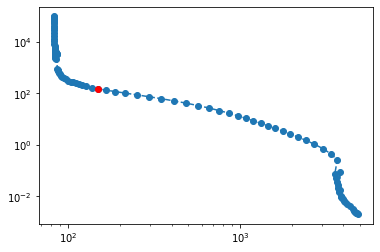

In [15]:
idx = 50
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

(0.0001, 1000.0)

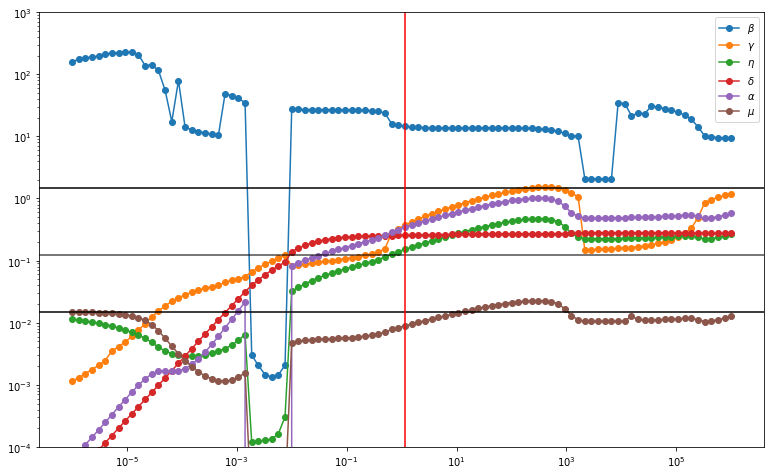

In [16]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-6]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-5]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-4]) for s in sols], 'o-', label=r'$\eta$')
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\delta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\mu$')
for q in p0:
    plt.axhline(q, color='k')
plt.axhline(0.125, color='k', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()
plt.ylim([1e-4, 1e3])

28.8122


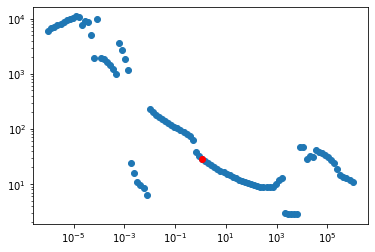

In [17]:
def r0(sol):
    b, g, e, d, a, m = getp(sol['x'])
    return b/(e+a+m)
plt.semilogx(prange, [r0(sol) for sol in sols], 'o')
plt.semilogx(prange[idx], r0(sols[idx]), 'ro')
print(r0(sols[idx]))
plt.yscale('log')

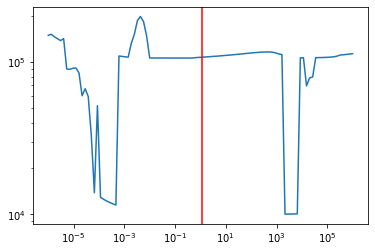

In [18]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(prange, [getN(i) for i,_ in enumerate(prange)])
plt.axvline(prange[idx], color='r')

(DM(14.4854), DM(0.374056), DM(0.151983), DM(0.255292), DM(0.341822), DM(0.00894611))


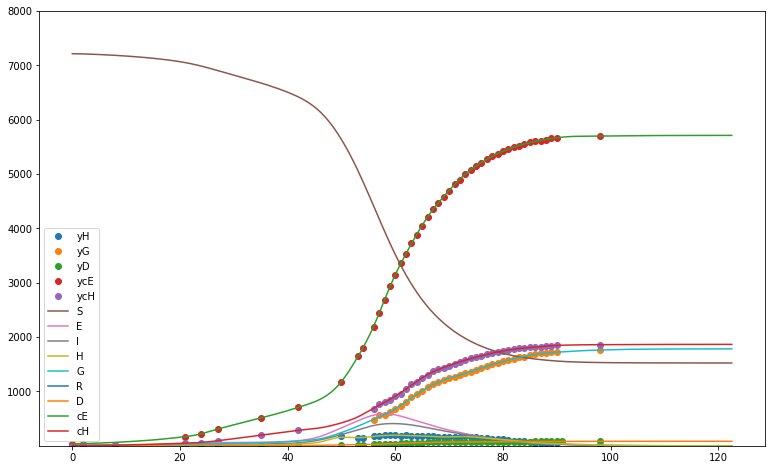

In [19]:
fig, ax=plt.subplots(figsize=[13, 8])
for data_dots in [H,G,D,cE,cH]:
    ax.plot(time, data_dots, 'o')
for data_stripe in getx(sols[idx]['x']):
    ax.plot(model.observation_times, data_stripe)
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
plt.ylim([1e-5, 8000])
print(getp(sols[idx]['x']))

In [20]:
print(list(zip("bgedam", getp(sols[idx]['x']))))

[(lbl, yyy[np.argmin(np.abs(model.observation_times-65))]) for lbl, yyy in zip('seihgrdEH', getx(sols[idx]['x'])) ]

[('b', DM(14.4854)), ('g', DM(0.374056)), ('e', DM(0.151983)), ('d', DM(0.255292)), ('a', DM(0.341822)), ('m', DM(0.00894611))]


[('s', DM(2651.79)),
 ('e', DM(421.208)),
 ('i', DM(346.404)),
 ('h', DM(181.122)),
 ('g', DM(1028.82)),
 ('r', DM(98637.5)),
 ('d', DM(59.5622)),
 ('E', DM(4098.08)),
 ('H', DM(1266.46))]

83.3413


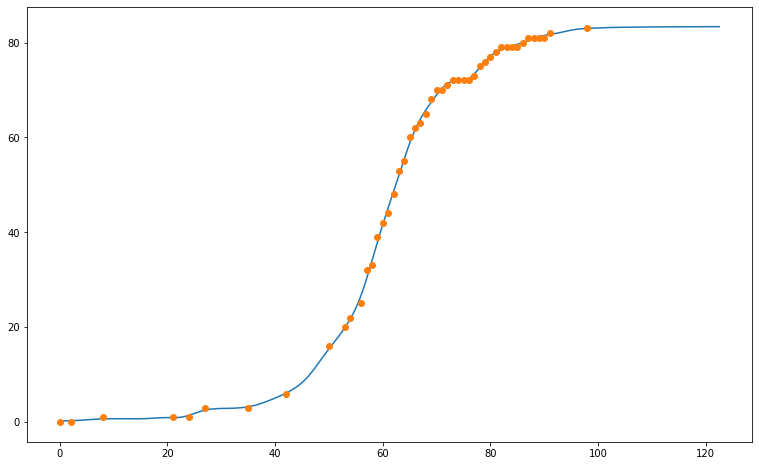

In [21]:
plt.figure(figsize=[13,8])
plt.plot(model.observation_times, getx(sols[idx]['x'])[6])
plt.plot(time, D, 'o')
print(getx(sols[idx]['x'])[6][-1])

(0, 6000)

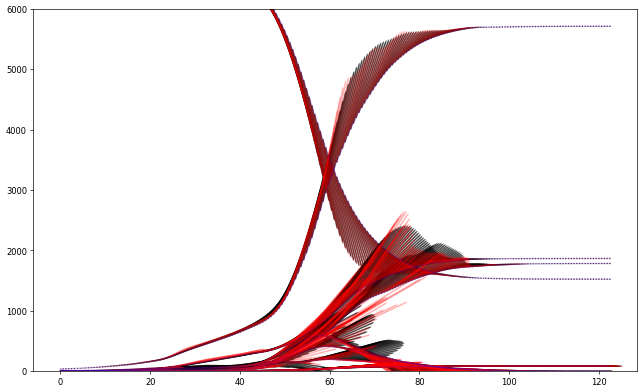

In [22]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
xx = np.vstack([xix.toarray().flatten() for xix in getx(sols[idx]['x'])])
dxxdt = np.vstack([seir(0, xxj, [float(q) for q in getp(sols[idx]['x'])]) for xxj in xx.T])
plt.plot(model.observation_times, xx.T, alpha=0.2, color='b')
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), dxxdt[:,i], 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.7)
for i, xxi in enumerate(xx):
    ax.quiver(model.observation_times, xxi, np.gradient(model.observation_times), np.gradient(xxi, model.observation_times), color='r', 
              angles='xy', headwidth=0.75, headlength=1, headaxislength=2, width=0.0025, alpha=0.3)
plt.ylim([0, 6000])

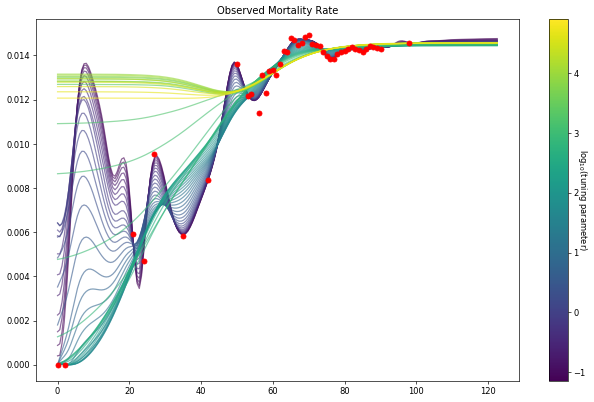

In [39]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors
i0, i1 = (40, -10)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

plt.figure(figsize=[13,8], dpi=60)
for i,p in enumerate(prange[i0:i1]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[6]/getx(sols[i+i0]['x'])[-2], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.6)
# plt.ylim(0, 0.04)
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.title("Observed Mortality Rate")
plt.plot(time, D/cE, 'ro')

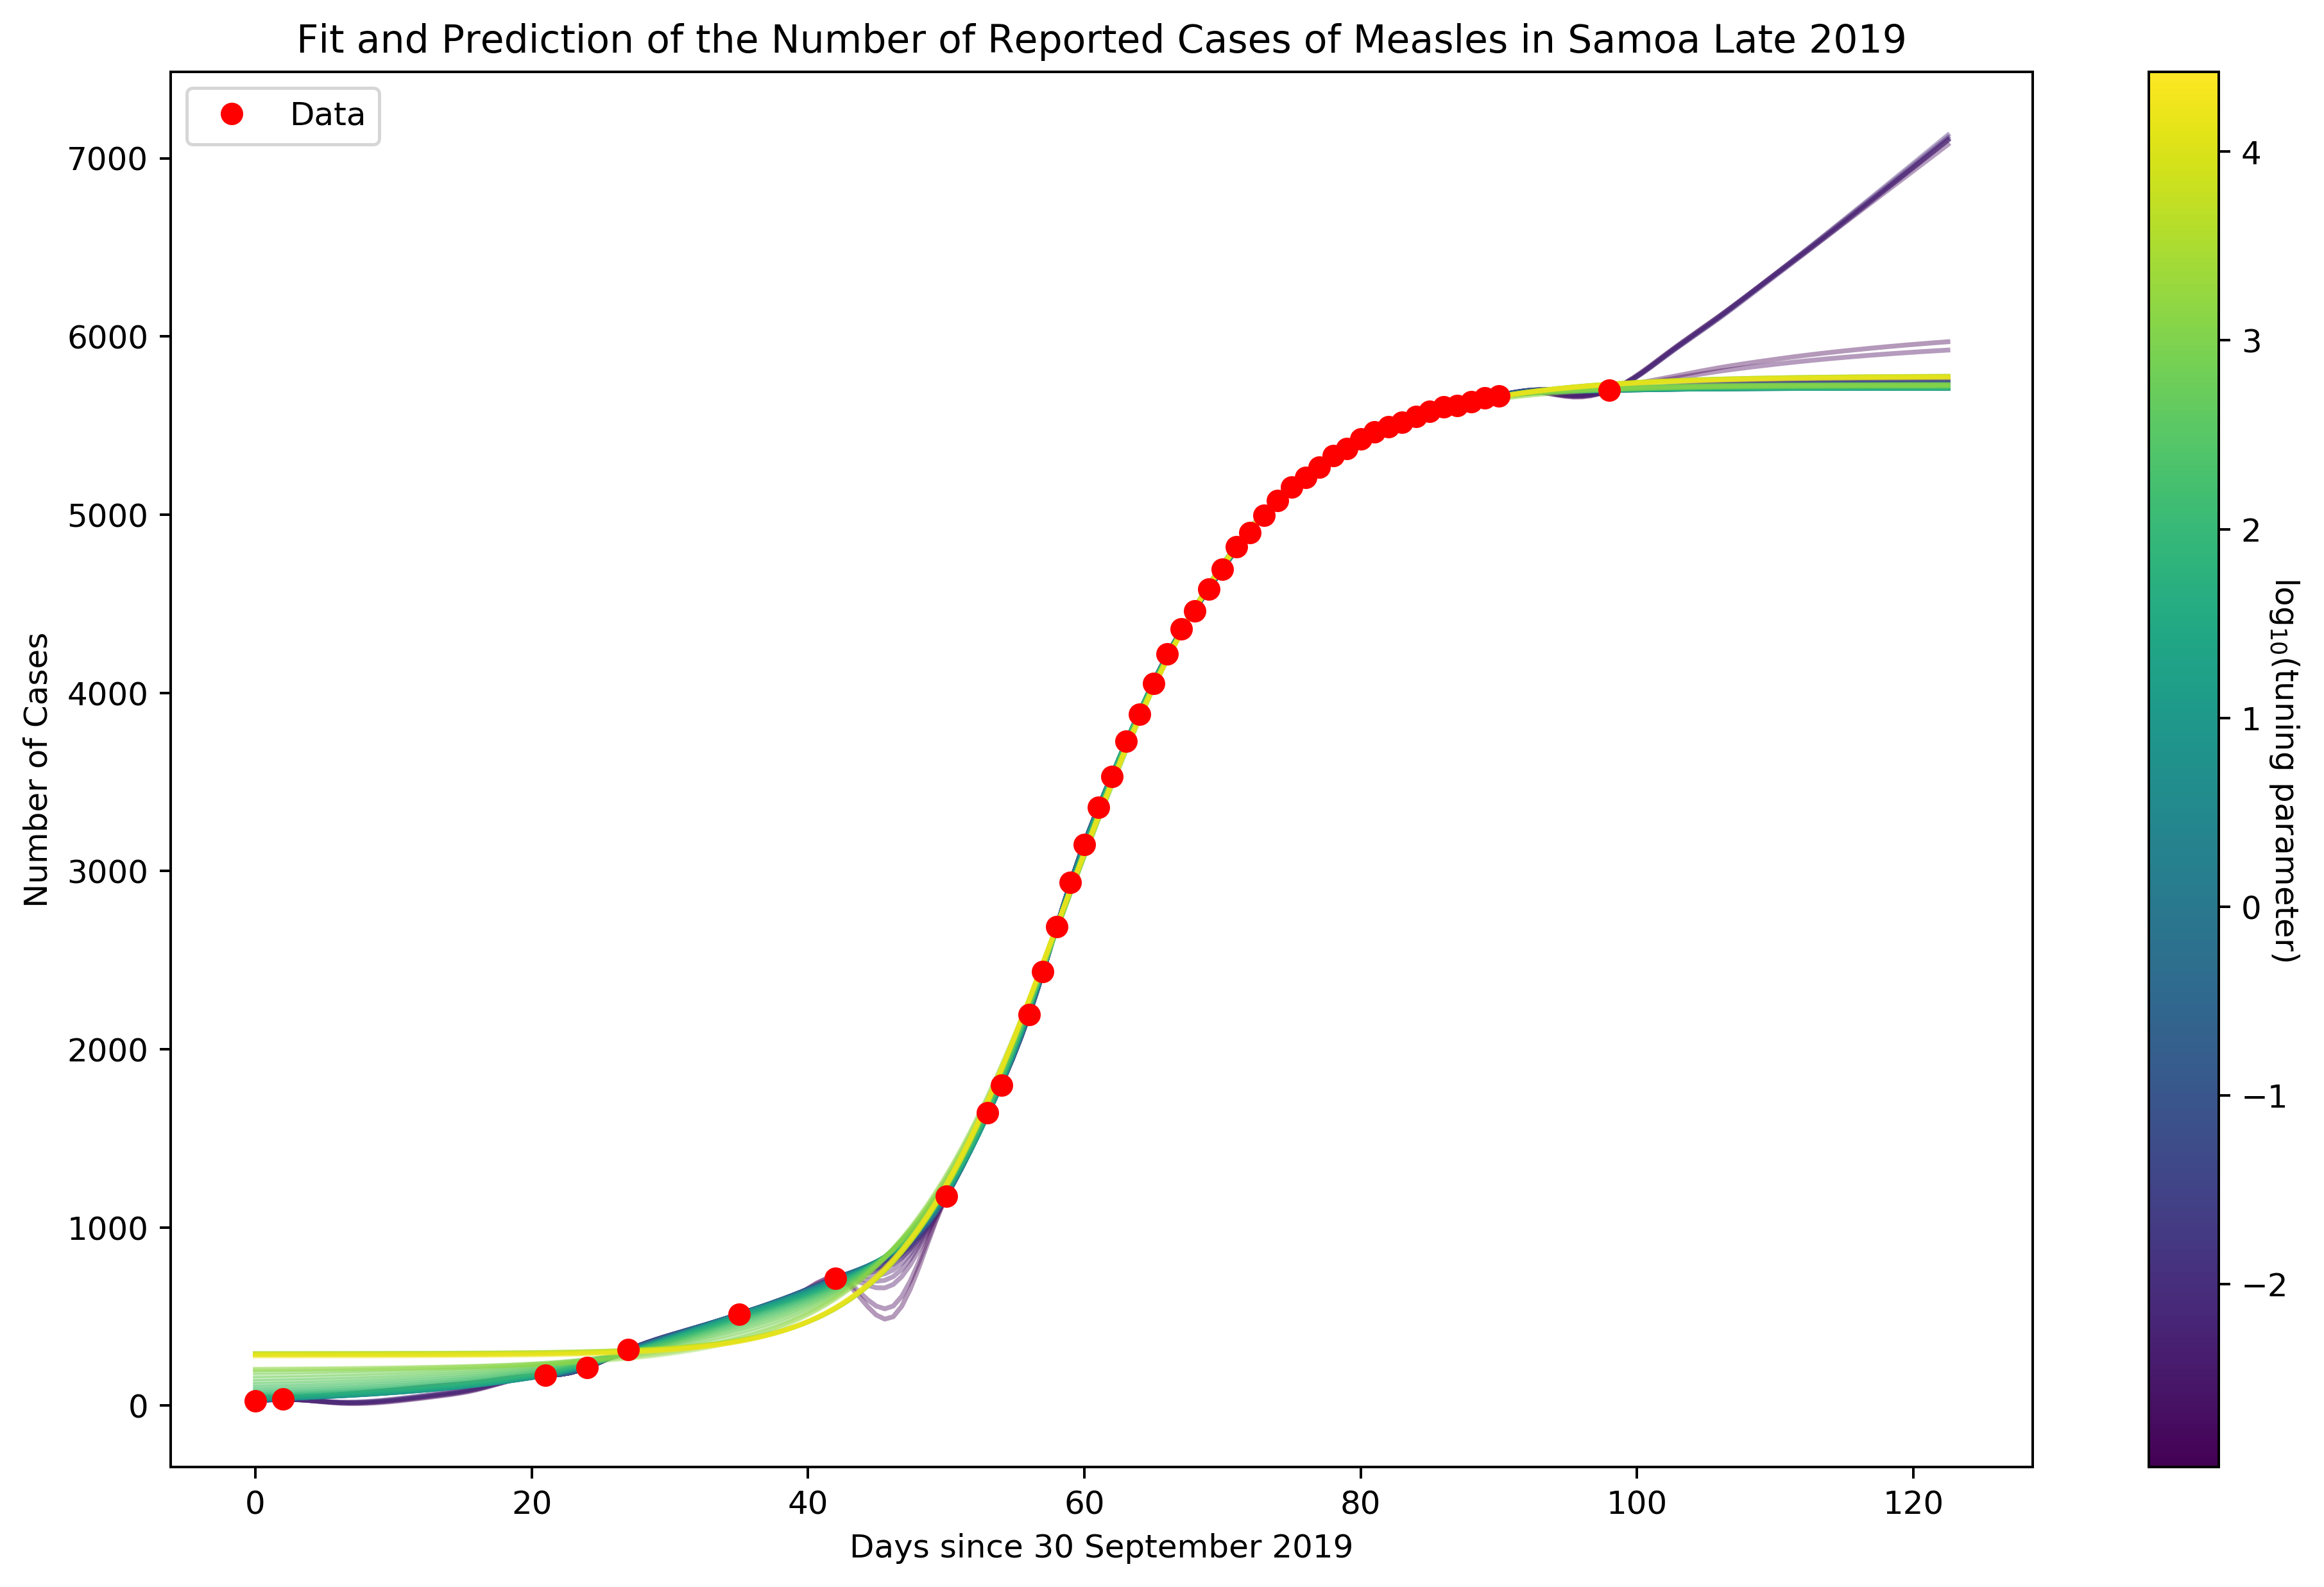

In [24]:
plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (25, -14)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[-2], color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(time, cE, 'ro', label="Data")
plt.title("Fit and Prediction of the Number of Reported Cases of Measles in Samoa Late 2019")
plt.xlabel("Days since 30 September 2019")
plt.ylabel("Number of Cases")
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()

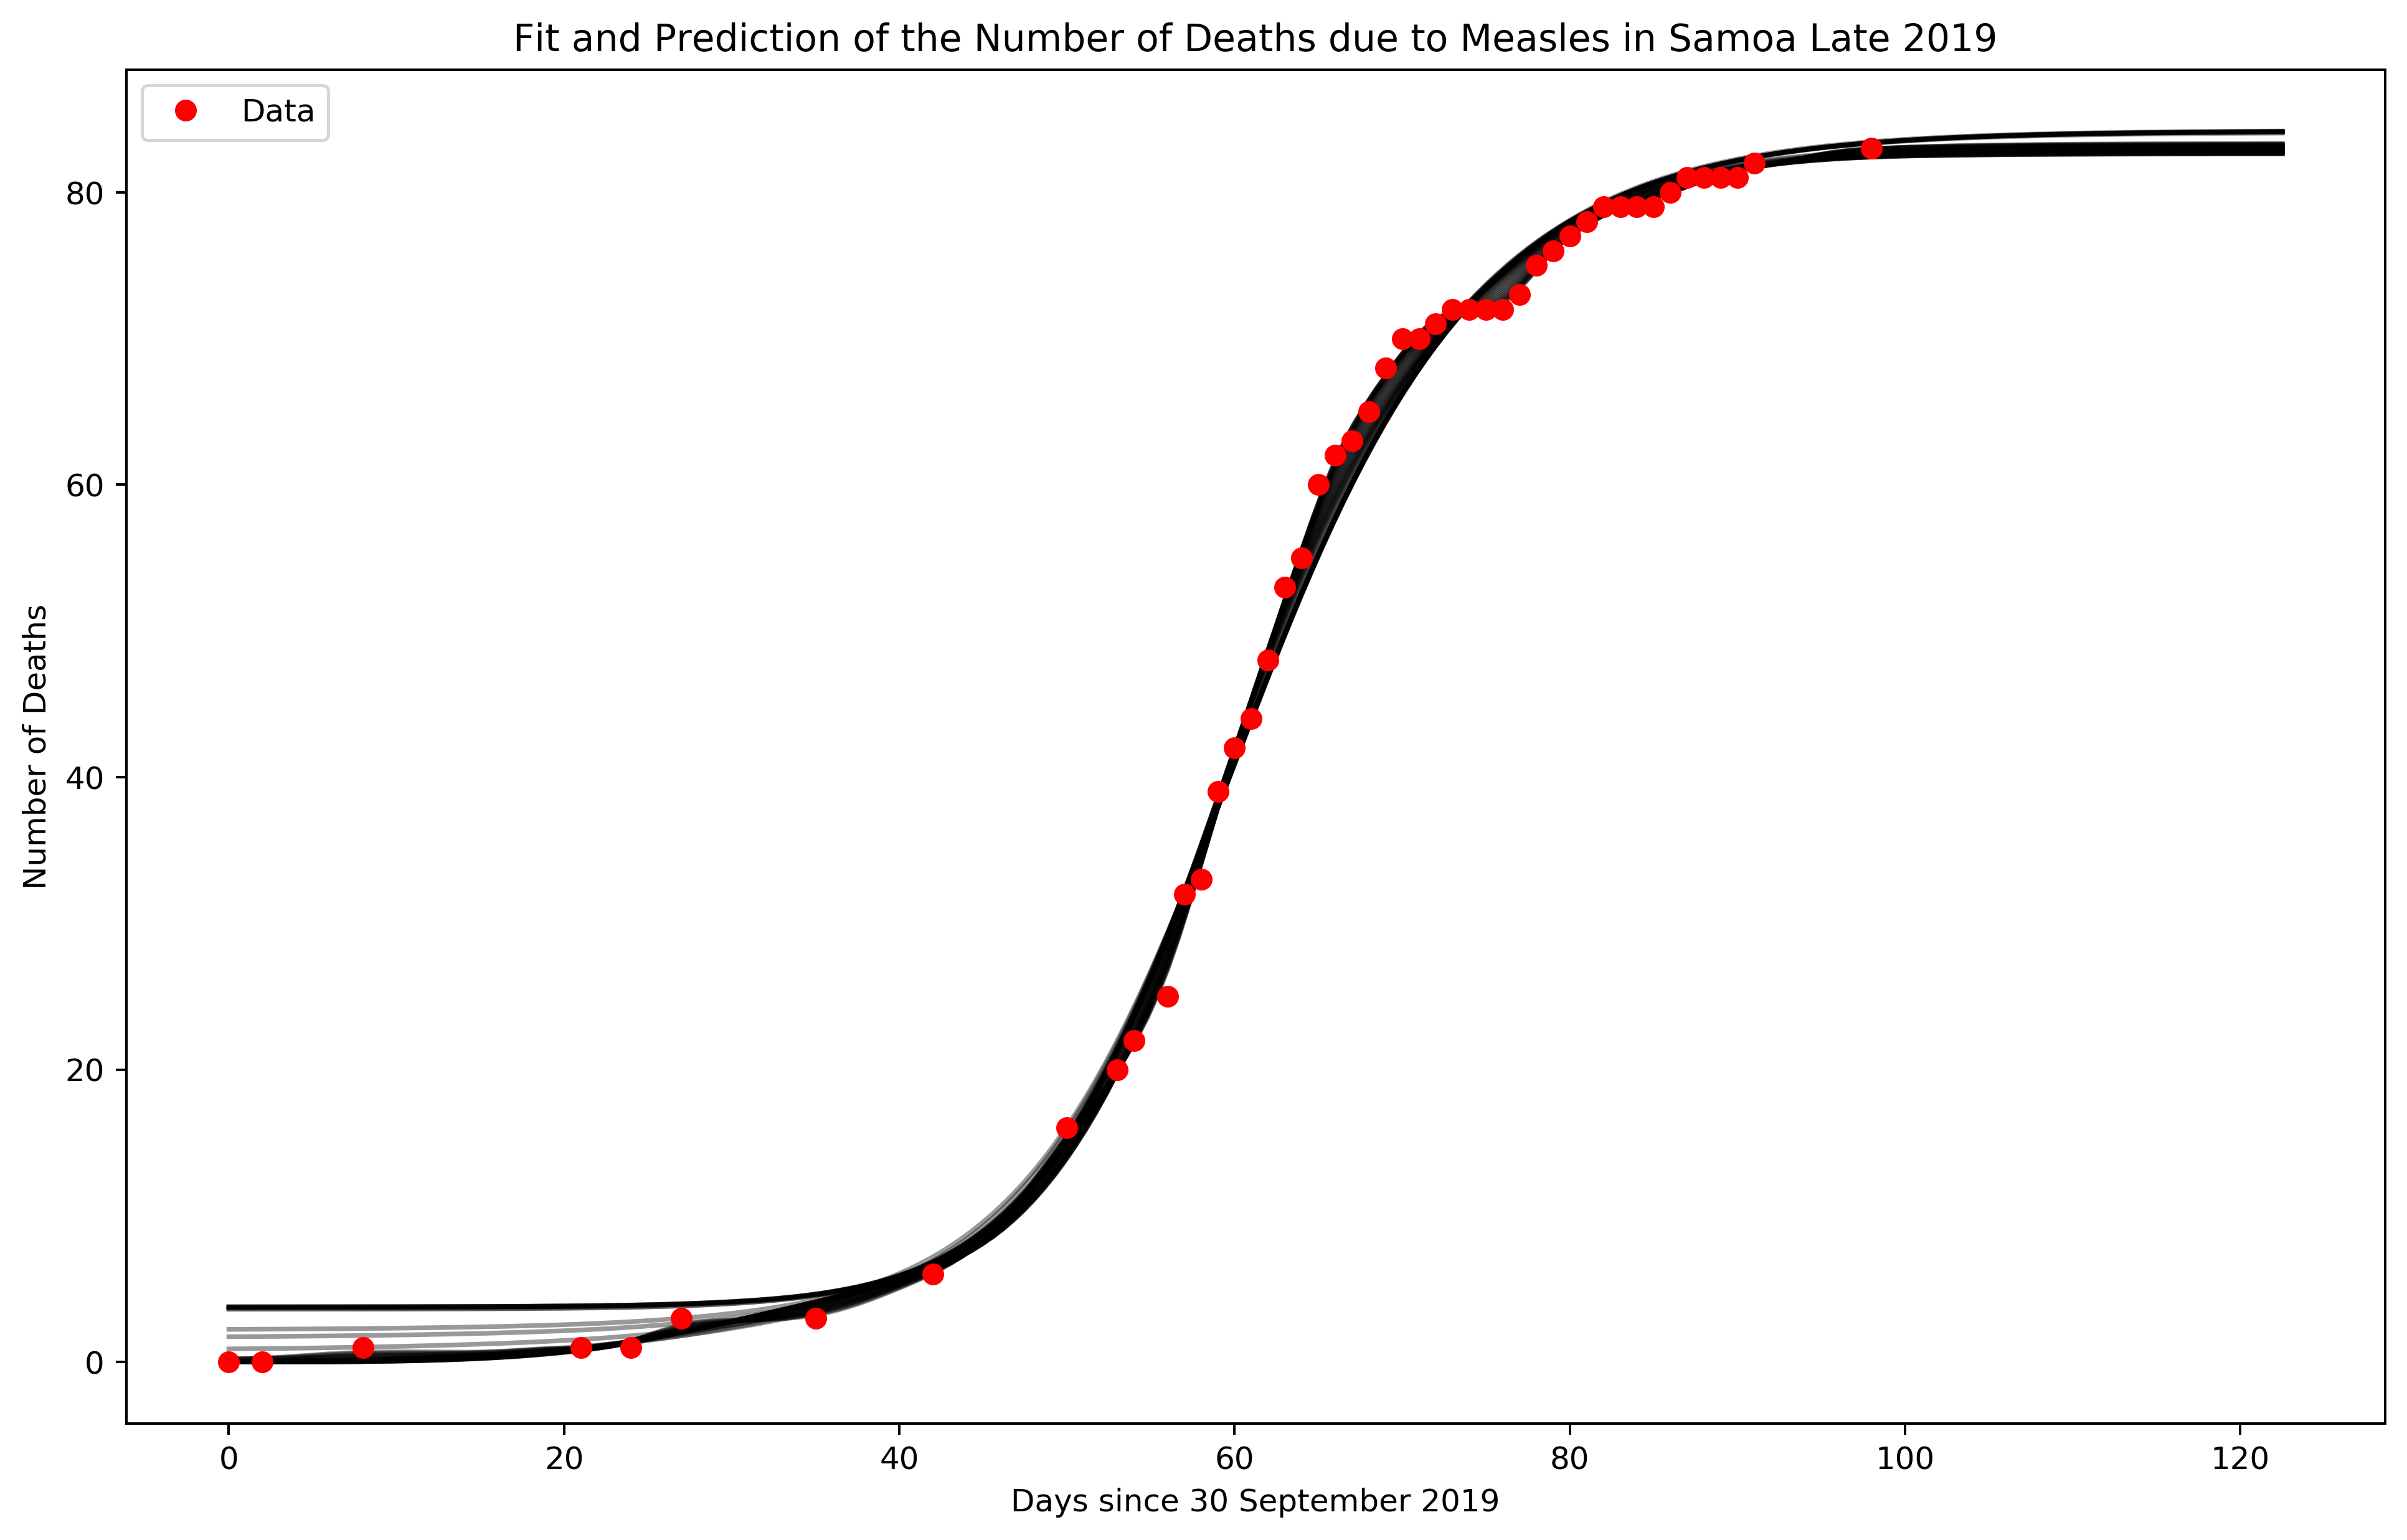

In [25]:
plt.figure(figsize=[13,8], dpi=360)

i0, i1 = (50, -14)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[6], color='k', alpha=0.4)
plt.plot(time, D, 'ro', label="Data")
plt.title("Fit and Prediction of the Number of Deaths due to Measles in Samoa Late 2019")
plt.xlabel("Days since 30 September 2019")
plt.ylabel("Number of Deaths")
# cbar = plt.colorbar(scalarMap)
# cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)
plt.legend()

array([5751.65243994, 5751.65243994])

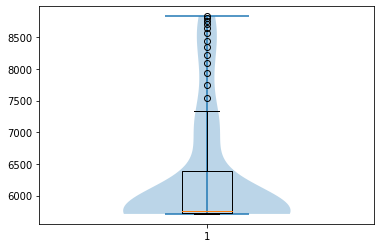

In [26]:
plt.violinplot([getx(sols[i]['x'])[-2][-1] for i in range(100)])
bx=plt.boxplot([getx(sols[i]['x'])[-2][-1] for i in range(100)])
bx['medians'][0].get_ydata()
# plt.yscale('log')

In [27]:
np.min([getx(sols[i]['x'])[-2][-1] for i in range(100)])

5709.415838321149

In [28]:
np.unique(bx['boxes'][0].get_ydata())

array([5722.11818579, 6380.81259611])

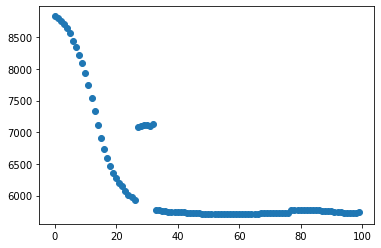

In [29]:
plt.plot([getx(sols[i]['x'])[-2][-1] for i in range(100)],'o')

(0, 100)

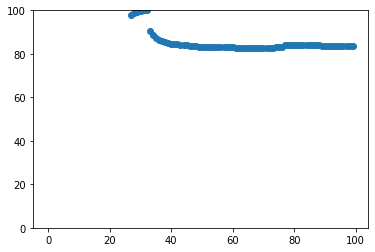

In [30]:
plt.plot([getx(sols[i]['x'])[6][-1] for i in range(100)],'o')
plt.ylim([0, 100])

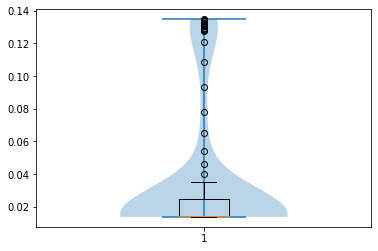

In [31]:
plt.violinplot([(getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])[-1] for i in range(100)])
bx = plt.boxplot([(getx(sols[i]['x'])[6]/getx(sols[i]['x'])[-2])[-1] for i in range(100)])


In [37]:
np.unique(bx['boxes'][0].get_ydata())

array([ 83.3017891 , 147.60485173])

In [33]:
morts = [getx(sols[i]['x'])[6][-1] for i in range(100)]
print(np.min(morts))
print(np.median(morts))

82.62518130633458
84.12815564236857


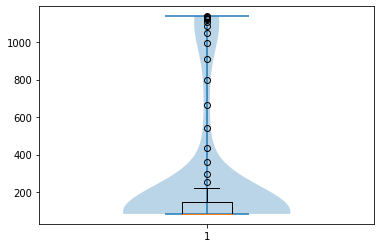

In [34]:
plt.violinplot(morts)
bx = plt.boxplot(morts)


In [35]:
np.unique(bx['boxes'][0].get_ydata())

array([ 83.3017891 , 147.60485173])

In [36]:
from scipy import interpolate

print(interpolate.interp1d(model.observation_times, getx(sols[idx]['x'])[-2].toarray().flatten())(data_time[-1]+1))
print(interpolate.interp1d(model.observation_times, getx(sols[idx]['x'])[-3].toarray().flatten())(data_time[-1]+1))

5698.787448574795
83.035166108571
